In [1]:
import quantum_kan 
import symengine as se
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import mean_squared_error, r2_score
from pyqubo import Binary, Array
import os
from dwave.embedding.chain_breaks import majority_vote
from dimod import BinaryQuadraticModel
import dwave.inspector
# Solve the QUBO using a quantum annealer
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler, FixedEmbeddingComposite
from dwave.embedding.chain_strength import uniform_torque_compensation
import time 
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from qkan import KAN
import torch.nn as nn
import minorminer
import networkx as nx

# Set your D-Wave API token
import os
env_vars = !cat dwave.env
for var in env_vars:
    key, value = var.split('=')
    os.environ[str(key)] = str(value)
#Advantage_system6.4 or Advantage2_prototype2.3
# sampler = EmbeddingComposite(DWaveSampler(solver='Advantage2_prototype2.3'))
sampler = LeapHybridSampler(solver="hybrid_binary_quadratic_model_version2")

simulated_sampler = SimulatedAnnealingSampler()

# Set the number of threads for intra-op parallelism (used for CPU operations)
torch.set_num_threads(1)

# Set the number of threads for inter-op parallelism (used for parallelism between operations)
torch.set_num_interop_threads(1)

# Verify the settings
print(f"Number of intra-op threads: {torch.get_num_threads()}")
print(f"Number of inter-op threads: {torch.get_num_interop_threads()}")


Number of intra-op threads: 1
Number of inter-op threads: 1


In [2]:
def convert_sympy_to_pyqubo(objective_func, conversion_dict):
    # Parse the simplified symbolic equation and update the QUBO matrix
    
    expression = mse_with_penalty_str
    pyqubo_expr = 0
    # Replace '-' with '+-' to simplify splitting
    expression = expression.replace(' - ', ' + -')
    # Split the expression into terms
    terms = expression.split(' + ')
    pyqubo_obj = 0

    for term in terms:
        # Split term into coefficient and variable parts
        parts = term.split('*')
        current_pyqubo_term = int(0)
        first_var = True
        for part in parts:
            if ('P' in part) or ('AUX' in part):
                current_pyqubo_var = conversion_dict.get(part)
            else:
                current_pyqubo_var = float(part)
                
            if first_var:
                current_pyqubo_term = current_pyqubo_var
                first_var = False
            else:
                current_pyqubo_term = current_pyqubo_term * current_pyqubo_var
        # current_pyqubo_term = current_pyqubo_term * coeff
        pyqubo_obj += current_pyqubo_term
        del current_pyqubo_term
        
    return pyqubo_obj

# Define the Bernstein polynomial basis functions
def bernstein_basis_functions(x, degree):
    """
    Calculates the Bernstein polynomial basis functions.

    Args:
        x (array-like): Points at which to evaluate the basis functions.
        degree (int): Degree of the Bernstein polynomial.

    Returns:
        numpy.ndarray: A 2D array of shape (n_basis, len(x)), where each row 
                       represents a basis function evaluated at the points in x.
    """
    n = degree
    basis = np.zeros((n+1, len(x)))

    for i in range(n+1):
        binomial_coeff = math.comb(n, i)
        basis[i, :] = binomial_coeff * (x**i) * ((1 - x)**(n - i))

    return basis

def bernstein_poly(i, n, t):
    """Compute the Bernstein polynomial B_i^n at t."""
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(coefficients, t):
    """Compute a Bezier curve given coefficients and parameter t."""
    n = len(coefficients) - 1
    return sum(coefficients[i] * bernstein_poly(i, n, t) for i in range(n + 1))

# Normalize x_data and y_data
def normalize(data):
    data_min, data_max = data.min(), data.max()
    return (data - data_min) / (data_max - data_min)


# Define a custom base function that always returns zero
class ZeroBaseFunction(nn.Module):
    def forward(self, x):
        return torch.zeros_like(x)
    
def separate_vars(solution):
    """
    Separate coefficients and auxiliary variables from the solution dictionary.

    :param solution: The solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {k: v for k, v in solution.items() if k.startswith('aux')}
    coeff_vars = {k: v for k, v in solution.items() if k.startswith('coeff')}
    
    return aux_vars, coeff_vars

def create_reverse_lookup_dict(original_dict):
    """
    Create a reverse lookup dictionary from the given dictionary.

    :param original_dict: The original dictionary to reverse.
    :return: A new dictionary where keys are the original values and values are the original keys.
    """
    reverse_dict = {v: k for k, v in original_dict.items()}
    return reverse_dict

def map_solution_variables(solution, reverse_dict):
    """
    Map solution variables from PyQUBO to SymPy using the reverse dictionary.

    :param solution: The solution dictionary with PyQUBO variables.
    :param reverse_dict: The reverse lookup dictionary to map PyQUBO variables to SymPy variables.
    :return: A new dictionary with SymPy variables as keys and solution values.
    """
    mapped_solution = {}
    for pyqubo_var, value in solution.items():
        sympy_var = reverse_dict.get(Binary(pyqubo_var))
        if sympy_var is not None:
            mapped_solution[sympy_var] = value
        else:
            print(f"Warning: PyQUBO variable {pyqubo_var} not found in reverse mapping.")
    return mapped_solution

def separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary=False):
    """
    Separate coefficients and auxiliary variables from the mapped solution dictionary.

    :param mapped_solution: The mapped solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if str(k).replace('"','').replace("'","").startswith('AUX')}
    if include_aux_in_binary == True:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if  str(k).replace('"','').replace("'","")}
    else:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if not str(k).replace('"','').replace("'","").startswith('AUX')}
    
    return aux_vars, binary_vars

def check_aux_variables(binary_vars, aux_vars, aux_dict_all):
    """
    Check if auxiliary variables correctly represent the product of their respective binary variables.

    :param binary_vars: Dictionary of binary variable values (e.g., {'x1': 0, 'x2': 1, ...})
    :param aux_vars: Dictionary of auxiliary variable values (e.g., {'z1': 1, 'z2': 0, ...})
    :param aux_dict_all: Dictionary mapping auxiliary variables to their respective binary variable products
                         (e.g., {'z1': x1*x2, 'z2': x2*x3, ...})
    :return: Dictionary indicating whether each auxiliary variable is correct (e.g., {'z1': True, 'z2': False, ...})
    """
    results = {}

    for aux_var, aux_expr in aux_dict_all.items():
        # Extract the binary variables involved in the product
        vars_in_expr = aux_expr.split('*')
        product_value = 1
        aux_var = str(aux_var)

        # Calculate the expected value by multiplying the values of the binary variables
        for var in vars_in_expr:
            var = str(var)
            if var in binary_vars:
                product_value *= binary_vars[var]
            else:
                raise ValueError(f"Variable {var} not found in binary_vars dictionary")

        # Check if the auxiliary variable's value matches the expected product value
        if aux_var in aux_vars:
            results[aux_var] = (aux_vars[aux_var] == product_value)
        else:
            raise ValueError(f"Auxiliary variable {aux_var} not found in aux_vars dictionary")

    return results
    
def create_dataset(f, 
                   n_var=2, 
                   ranges = [0,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=True,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [0,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:, i] = torch.rand(train_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        test_input[:, i] = torch.rand(test_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        
    train_label = f(train_input)
    test_label = f(test_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = (train_label - mean_label) / std_label
        test_label = (test_label - mean_label) / std_label

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)
    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset

def split_dataset(dataset, splits):
    """
    Split dataset into multiple smaller datasets.
    
    Args:
    -----
        dataset : dict
            The dataset containing 'train_input' and 'train_label'.
        splits : list
            List of integers specifying the size of each split.
            
    Returns:
    --------
        split_datasets : list
            List of datasets, each containing 'train_input' and 'train_label'.
    """
    total_size = sum(splits)
    assert total_size == len(dataset['train_input']), "Sum of splits must equal the total dataset size."
    
    # Create a list of indices and shuffle them
    indices = torch.randperm(total_size)
    
    split_datasets = []
    start_idx = 0
    
    for split_size in splits:
        end_idx = start_idx + split_size
        split_indices = indices[start_idx:end_idx]
        
        split_input = dataset['train_input'][split_indices]
        split_label = dataset['train_label'][split_indices]
        
        split_dataset = {
            'train_input': split_input,
            'train_label': split_label,
            'test_input': torch.empty(0, split_input.shape[1]),  # Empty tensor with the same number of columns as train_input
            'test_label': torch.empty(0, split_label.shape[1])   # Empty tensor with the same number of columns as train_label
        }
        
        split_datasets.append(split_dataset)
        start_idx = end_idx
        
    return split_datasets



In [3]:
def train_classical_optimizer(dataset, degrees, optimizer, steps, learning_rates, T, U, Z_ideal, Z_ideal_flat):
    best_lr = None
    best_mse = 100000
    grid_points = np.c_[T.ravel(), U.ravel()]
    grid_points_tensor = torch.from_numpy(grid_points).float()

    for lr in learning_rates:
        model = KAN(width=[2, 1, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()
        start = time.perf_counter()
        results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=lr)
        end = time.perf_counter()
        training_time = end - start
        print(f"Training time in seconds of lr={lr}: {training_time}")  # will print the elapsed time in seconds

        # Compute the model predictions
        with torch.no_grad():
            Z_model = model(grid_points_tensor).numpy().reshape(T.shape)
            
        # Flatten the arrays for comparison
        Z_model_flat = Z_model.ravel()

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(Z_ideal_flat, Z_model_flat)
        r2 = r2_score(Z_ideal_flat, Z_model_flat)
        if mse < best_mse:
            best_mse = mse
            best_lr = lr
        print(f"Learning Rate: {lr}, Train MSE: {mse}, Train r2: {r2}")

    print(f"Best Learning Rate: {best_lr} with Train MSE: {best_mse}")

    # Plot the results using the best learning rate
    model = KAN(width=[2, 1, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()


    start = time.perf_counter()

    results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=best_lr)
    end = time.perf_counter()
    time_best_lr = end - start

    print(f"Training time in seconds: {time_best_lr}")  # will print the elapsed time in seconds

    # Print final Bezier coefficients for each layer
    for layer_idx, layer in enumerate(model.act_fun):
        print(f"Layer {layer_idx} Bezier coefficients:")
        print(layer.coef.data.cpu().numpy())

    # Compute the model predictions
    with torch.no_grad():
        Z_model = model(grid_points_tensor).numpy().reshape(T.shape)

    # Plot the ideal function
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Ideal Function')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot the model predictions
    plt.subplot(1, 2, 2)
    plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.tight_layout()
    plt.show()

    # Calculate metrics
    # Flatten the arrays for comparison
    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    r2 = r2_score(Z_ideal_flat, Z_model_flat)

    print(f"Training time: {time_best_lr}, mse: {mse}, r2: {r2}")

    return time_best_lr, mse, r2

In [4]:
def run_annealing(type, sampler, problem, chain_strength, time_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=1000, annealing_time=20):
    #Check if quantum annealer, hybrid quantum annealer, or simulated annealer
    if type == "QA":
        response = sampler.sample(problem, num_reads=num_reads, chain_strength=chain_strength, annealing_time=annealing_time)
        # Extract and print timing information
        timing_info = response.info['timing']

        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        time_part2 = qpu_access_time * (10**(-6))
        print(f"Time spent on quantum annealer part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "HQA":
        response = sampler.sample(problem)
        # Extract and print timing information
        timing_info = response.info

        # Print timing information
        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        dwave_run_time = timing_info.get('run_time', 'N/A')
        print(f"\nTotal D-Wave Run Time Including Setup: {dwave_run_time} microseconds")

        time_part2 = dwave_run_time * (10**(-6))
        print(f"Time spent on hybrid part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "SA":
        # Simulated annealing doesnt converge to a good solution as fast so generally takes more reads
        start_time_part2 = time.perf_counter()
        response = sampler.sample_qubo(problem, num_reads=num_reads)
        end_time_part2 = time.perf_counter()
        time_part2 = end_time_part2 - start_time_part2
        print(f"Time spent on simulated part 2: {time_part2}")  # will print the elapsed time in seconds
    
    # Start part 3
    start_time_part3 = time.perf_counter()
    solution = response.first.sample
    # Extract optimized coefficients
    optimized_coefficients_1 = []
    for i in range(num_basis_funcs_1):
        coeff_value_1 = sum(2**j * solution[f'coeff_plus_1[{i}][{j + m1 - 1}]'] for j in range(-m1 + 1, 1))
        optimized_coefficients_1.append(coeff_value_1)
        
    optimized_coefficients_2 = []
    for i in range(num_basis_funcs_2):
        coeff_value_2 = sum(2**j * solution[f'coeff_plus_2[{i}][{j + m2 - 1}]'] for j in range(-m2 + 1, 1))
        optimized_coefficients_2.append(coeff_value_2)
        
    optimized_coefficients_3 = []
    for i in range(num_basis_funcs_3):
        coeff_value_3 = sum(2**j * solution[f'coeff_plus_3[{i}][{j + m3 - 1}]'] for j in range(-m3 + 1, 1))
        optimized_coefficients_3.append(coeff_value_3)
        
    optimized_aux = []
    for i in range(num_aux):
        coeff_value_1 = solution[f'aux[{i}]']
        optimized_aux.append(coeff_value_1)
    end_time_part3 = time.perf_counter()

    time_part3 = end_time_part3 - start_time_part3
    print(f"Time spent on part 3: {time_part3}")  # will print the elapsed time in seconds

    total_time_optimization = time_part1 + time_part2 + time_part3
    print(f"Time spent on optimization: {total_time_optimization}")  # will print the elapsed time in seconds
    print(f"optimized_coefficients_1: {optimized_coefficients_1}")
    print(f"optimized_coefficients_2: {optimized_coefficients_2}")
    print(f"optimized_coefficients_3: {optimized_coefficients_3}")

    # Separate coefficients and auxiliary variables
    aux_vars, coeff_vars = separate_vars(solution)
    # Create reverse lookup dictionary
    reverse_dict = create_reverse_lookup_dict(sympy_to_pyqubo_map)
    # Map solution variables from PyQUBO to SymPy
    mapped_solution = map_solution_variables(solution, reverse_dict)
    include_aux_in_binary = True
    aux_vars, binary_vars = separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary)
    # Check the auxiliary variable values
    results_aux_check = check_aux_variables(binary_vars, aux_vars, aux_dict_str)

    # Print the results
    for aux_var, is_correct in results_aux_check.items():
        print(f"{aux_var}: {'Correct' if is_correct else 'Incorrect'}")

    # Compute Bézier curve values for each grid point
    B1_values = np.array([[bezier_curve(optimized_coefficients_1, t) + bias_coefficient * t**2 for t in t_row] for t_row in T])
    B2_values = np.array([[bezier_curve(optimized_coefficients_2, u) + bias_coefficient * u**2 for u in u_row] for u_row in U])


    # Compute Bézier3 using the output of Bézier1 and Bézier2
    Z_model = np.array([[bezier_curve(optimized_coefficients_3, (B1_values[i, j] + B2_values[i, j])) + bias_coefficient * (B1_values[i, j] + B2_values[i, j])**2 for j in range(len(T))] for i in range(len(U))])

    # Plotting the 3D surface plots side by side
    fig = plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Ideal Function')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot the model predictions
    plt.subplot(1, 2, 2)
    plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Quantum Annealing Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Calculate metrics
    # Flatten the arrays for comparison
    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    r2 = r2_score(Z_ideal_flat, Z_model_flat)

    print(f"Training time: {total_time_optimization}, MSE: {mse:.4f}, r2: {r2:.4f}")
    print(f"time_part1: {time_part1}, time_part2: {time_part2}, time_part3: {time_part3}")
    return time_part2, time_part3, total_time_optimization, mse, r2

In [5]:
# Defining variables for the networks
degree1 = 1
degree2 = 1
degree3 = 1
degrees=[degree1,degree3]
m1 = 1
m2 = 3
m3 = 3
penalty_multiplier = 25
bias_coefficient = 0.0
is_fractional=True

num_basis_funcs_1 = degree1 + 1
num_basis_funcs_2 = degree2 + 1
num_basis_funcs_3 = degree3 + 1

save_file1 = "35_18_mse_save1.json"
save_file2 = "35_18_mse_save2.json"
save_file3 = "35_18_mse_save3.json"
save_file4 = "35_18_mse_save4.json"

# Define variables to keep track of time
total_time_quantum = []
total_time_simulated = []
total_time_adam = []
total_time_sgd = []
total_time_adagrad = []

In [6]:
dataset_multiplier = 3
dataset_size = 2400000
# Create dataset with normalized inputs between 0 and 1
f = lambda x: x[:, [0]] / (np.exp(x[:, [1]]) + (np.exp( -1 * x[:, [1]]))) * dataset_multiplier
dataset = create_dataset(f, n_var=2, train_num=dataset_size, test_num=0, ranges=[0, 1])

# Define the sizes of the splits
splits = [2000000, 100000, 100000, 100000, 100000]

# Split the dataset
split_datasets = split_dataset(dataset, splits)

# Example usage
for i, split_dataset in enumerate(split_datasets):
    print(f"Dataset {i+1}:")
    print(f"  Input shape: {split_dataset['train_input'].shape}")
    print(f"  Label shape: {split_dataset['train_label'].shape}")
    if i == 0:
        dataset = split_dataset
    elif i == 1:
        dataset_split1 = split_dataset
    elif i == 2:
        dataset_split2 = split_dataset
    elif i == 3:
        dataset_split3 = split_dataset
    elif i == 4:
        dataset_split4 = split_dataset
    
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

# Generate a grid of t values for the 3D plot
t_values = np.linspace(0, 1, 30)
u_values = np.linspace(0, 1, 30)
T, U = np.meshgrid(t_values, u_values)

# Compute the ideal function values
ideal_func = lambda t, u: (t/ (np.exp(u) + np.exp(-1 * u))) * dataset_multiplier
Z_ideal = np.array([[ideal_func(t, u) for t, u in zip(t_row, u_row)] for t_row, u_row in zip(T, U)])

Z_ideal_flat = Z_ideal.ravel()


Dataset 1:
  Input shape: torch.Size([2000000, 2])
  Label shape: torch.Size([2000000, 1])
Dataset 2:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 3:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 4:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 5:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])


# Run Quantum Annealing

In [7]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file1
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()
    

In [8]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 1.040394519000074


Timing Information:
qpu_access_time: 115500 microseconds
charge_time: 2991292 microseconds
run_time: 2991292 microseconds
problem_id: 499b6844-fd66-438f-92ba-ac10e88c2cd4 microseconds

QPU Access Time: 115500 microseconds

Total D-Wave Run Time Including Setup: 2991292 microseconds
Time spent on hybrid part 2: 2.991292
Time spent on part 3: 0.0004906430003757123
Time spent on optimization: 4.032177162000449
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX3

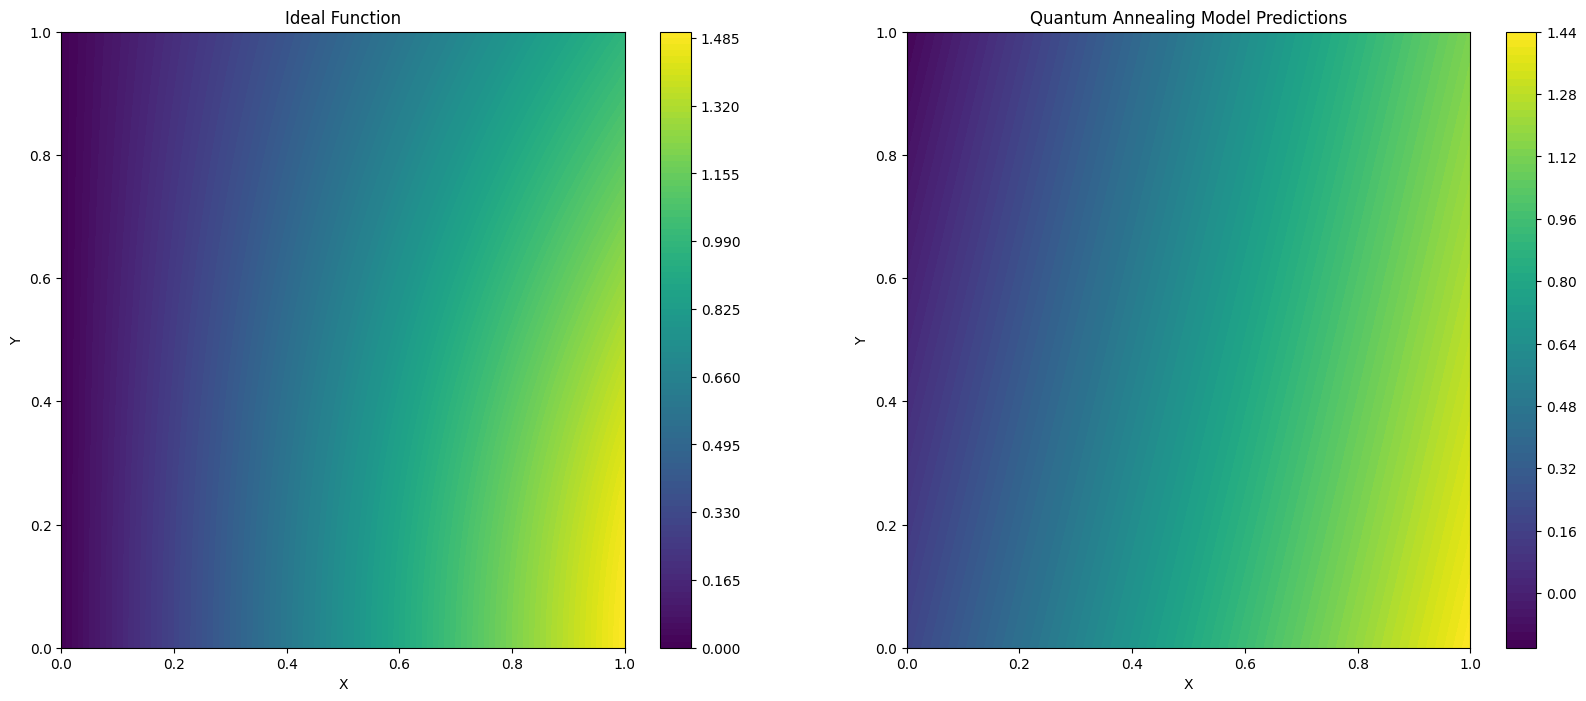

In [9]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 12.987472133000665
Time spent on part 3: 0.001375793000079284
Time spent on optimization: 14.029242445000818
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: C

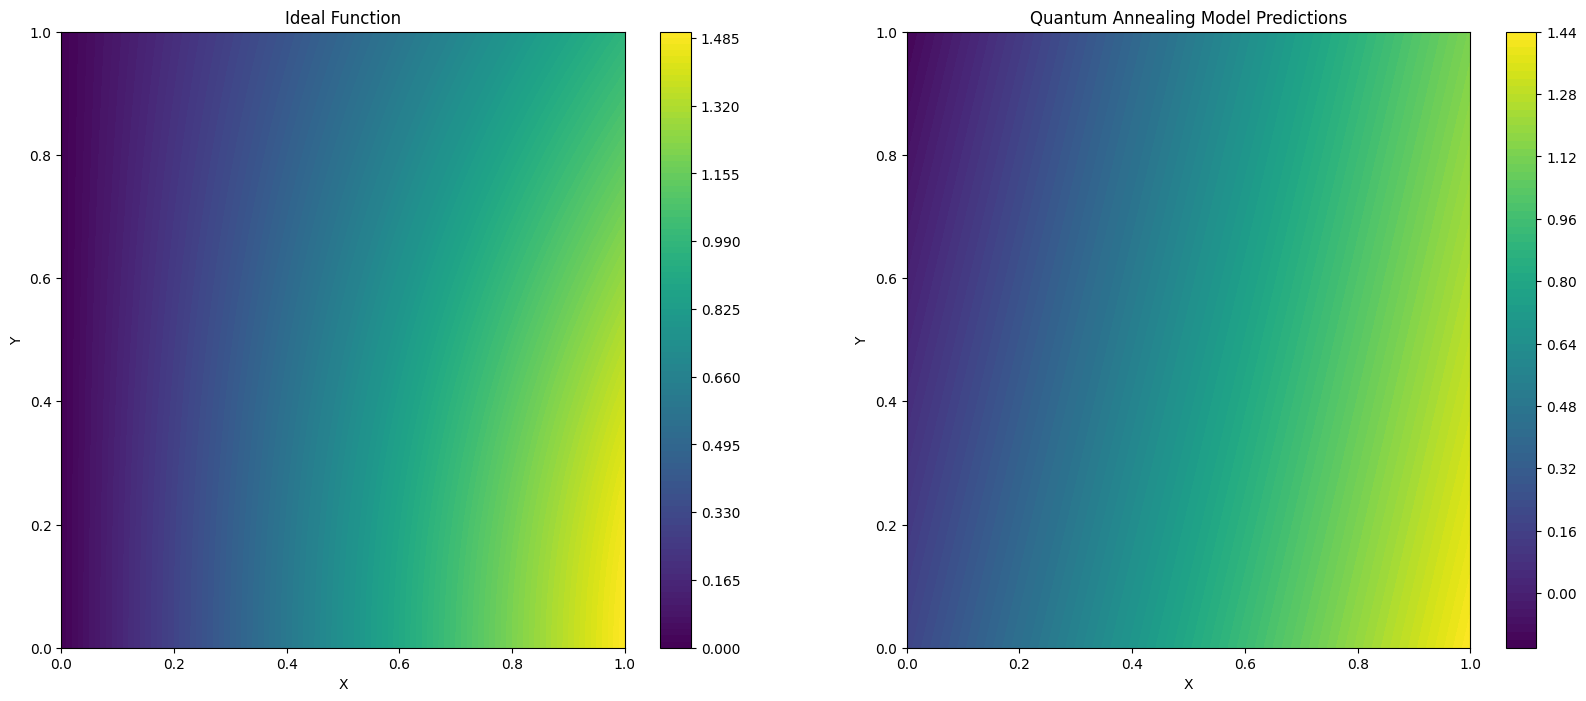

In [10]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.70e-01 | test loss: nan | reg: 5.08e+00 : 100%|███████| 72/72 [01:15<00:00,  1.04s/it]


Training time in seconds of lr=0.001: 75.16789147299914
Learning Rate: 0.001, Train MSE: 0.4522859907628908, Train r2: -1.8363769626045658


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.36e-01 | test loss: nan | reg: 3.38e+00 : 100%|███████| 72/72 [01:13<00:00,  1.02s/it]


Training time in seconds of lr=0.01: 73.5854005199999
Learning Rate: 0.01, Train MSE: 0.014743104875019597, Train r2: 0.9075430062420592


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.21e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:13<00:00,  1.02s/it]


Training time in seconds of lr=0.05: 73.79274920399985
Learning Rate: 0.05, Train MSE: 0.0029807148582255976, Train r2: 0.9813073340129246


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.03e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:13<00:00,  1.02s/it]


Training time in seconds of lr=0.1: 73.14794332499969
Learning Rate: 0.1, Train MSE: 0.0029403239943133824, Train r2: 0.9815606332931146


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.51e+00 : 100%|███████| 72/72 [01:13<00:00,  1.01s/it]


Training time in seconds of lr=0.2: 73.01548211599948
Learning Rate: 0.2, Train MSE: 0.0028408208900293575, Train r2: 0.9821846373933142


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.18e+00 : 100%|███████| 72/72 [01:12<00:00,  1.01s/it]


Training time in seconds of lr=0.5: 73.0025062069999
Learning Rate: 0.5, Train MSE: 0.0028669535926629476, Train r2: 0.9820207539274666
Best Learning Rate: 0.2 with Train MSE: 0.0028408208900293575


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.52e+00 : 100%|███████| 72/72 [01:12<00:00,  1.00s/it]


Training time in seconds: 72.16724453000006
Layer 0 Bezier coefficients:
[[ 1.4260445 -2.0167022]
 [-0.7826458  0.9406553]]
Layer 1 Bezier coefficients:
[[0.74956614 0.22840433]]


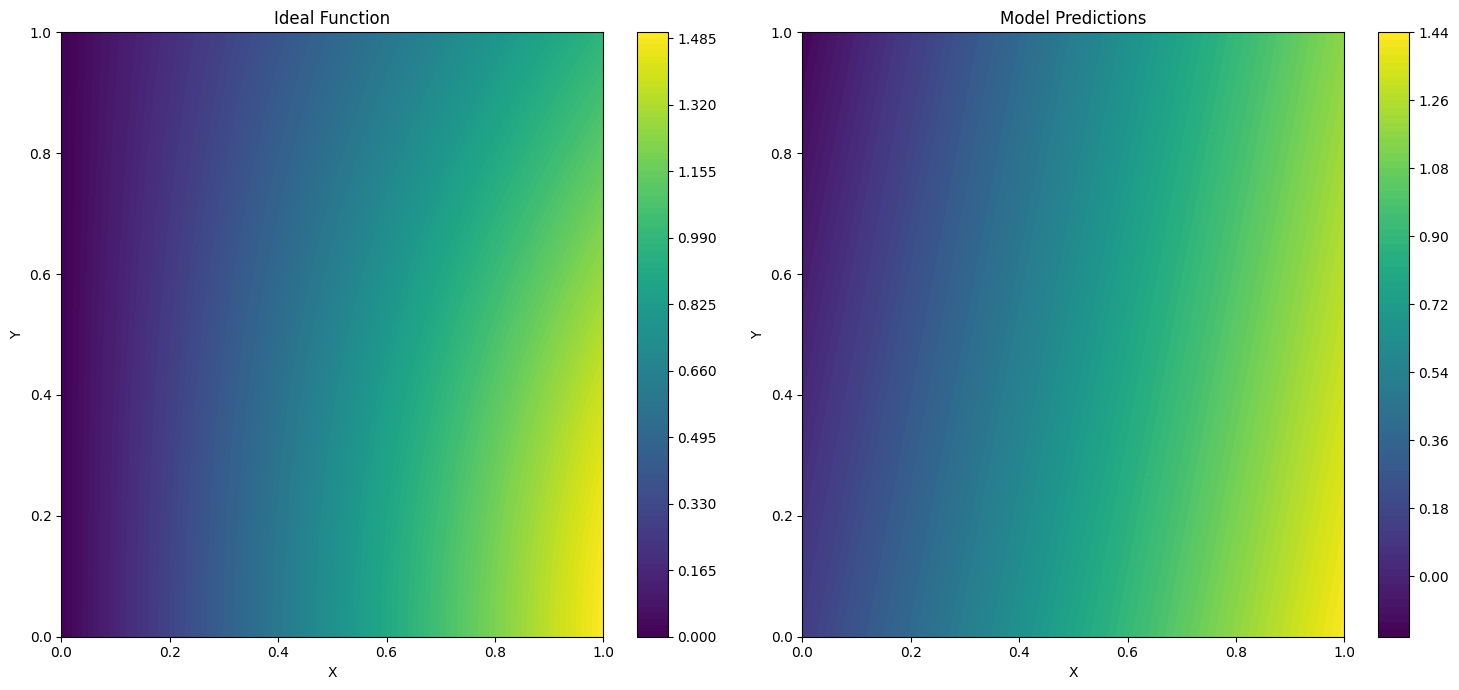

Training time: 72.16724453000006, mse: 0.002844064967889124, r2: 0.9821642931246561


In [11]:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
adam_steps = 72
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(dataset, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.85e-01 | test loss: nan | reg: 4.42e+00 : 100%|███████| 72/72 [01:12<00:00,  1.01s/it]


Training time in seconds of lr=0.001: 72.82542480099983
Learning Rate: 0.001, Train MSE: 0.4746784208582281, Train r2: -1.9768044225663859


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 3.80e-01 | test loss: nan | reg: 1.16e+01 : 100%|███████| 72/72 [01:11<00:00,  1.00it/s]


Training time in seconds of lr=0.01: 71.75448361500003
Learning Rate: 0.01, Train MSE: 0.15189409714019111, Train r2: 0.04744138292375588


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.80e-01 | test loss: nan | reg: 2.61e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.05: 71.30235035799979
Learning Rate: 0.05, Train MSE: 0.030857418475838314, Train r2: 0.8064868851173416


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.1: 71.53787219400056
Learning Rate: 0.1, Train MSE: 0.0028534180253112795, Train r2: 0.9821056382090851


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:12<00:00,  1.00s/it]


Training time in seconds of lr=0.2: 72.1738328270003
Learning Rate: 0.2, Train MSE: 0.002793864963868994, Train r2: 0.9824791075072223


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.59e-02 | test loss: nan | reg: 2.35e+00 : 100%|███████| 72/72 [01:12<00:00,  1.00s/it]


Training time in seconds of lr=0.5: 72.14396822900017
Learning Rate: 0.5, Train MSE: 0.004344245846719101, Train r2: 0.9727563552902873
Best Learning Rate: 0.2 with Train MSE: 0.002793864963868994


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds: 71.21353072500006
Layer 0 Bezier coefficients:
[[ 0.5522934  -0.44520488]
 [-0.07879898  0.17840865]]
Layer 1 Bezier coefficients:
[[ 0.65354836 -0.25029534]]


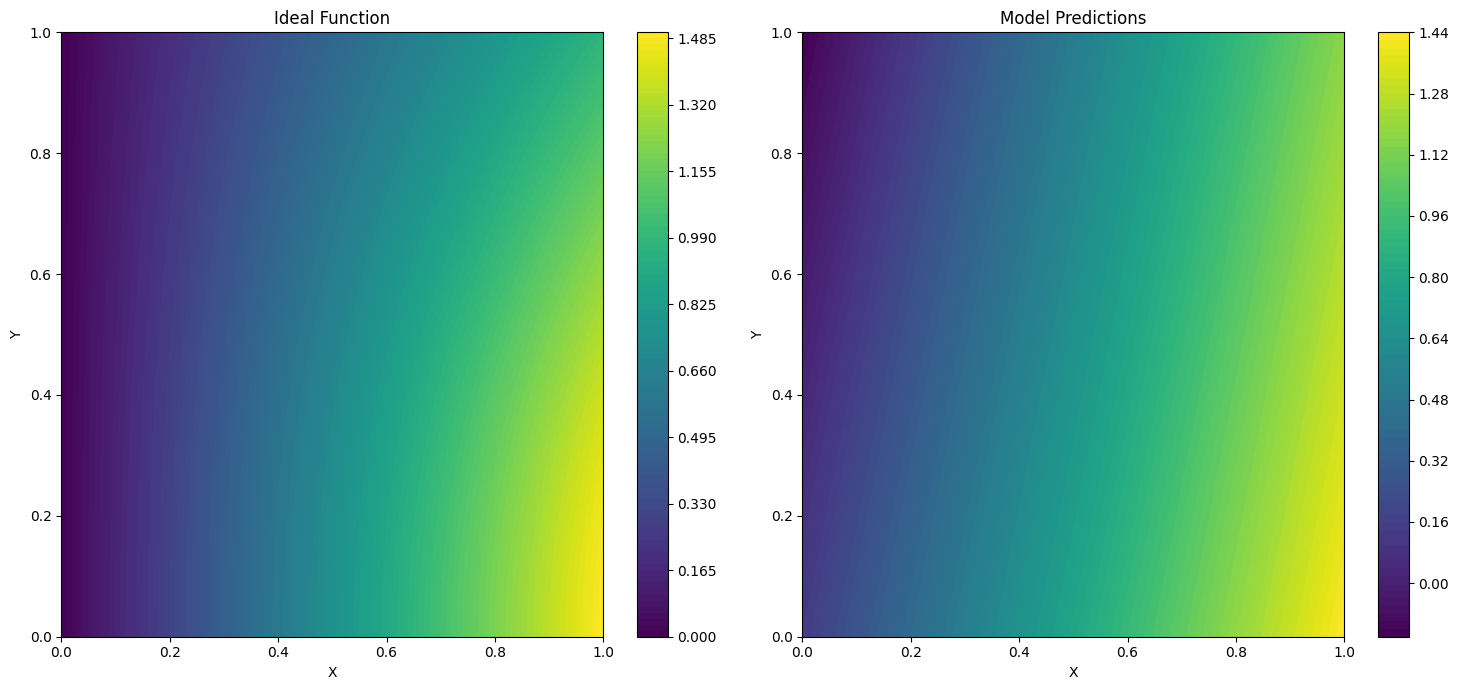

Training time: 71.21353072500006, mse: 0.002793866060839058, r2: 0.9824791006279011


In [12]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(dataset, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 7.41e-01 | test loss: nan | reg: 2.49e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.001: 71.23285024600045
Learning Rate: 0.001, Train MSE: 0.5572191859959363, Train r2: -2.494434261857793


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.80e-01 | test loss: nan | reg: 1.44e+01 : 100%|███████| 72/72 [01:10<00:00,  1.02it/s]


Training time in seconds of lr=0.01: 70.7347029829998
Learning Rate: 0.01, Train MSE: 0.23406160134704315, Train r2: -0.46784766154547386


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.14e-02 | test loss: nan | reg: 2.39e+00 : 100%|███████| 72/72 [01:11<00:00,  1.00it/s]


Training time in seconds of lr=0.05: 71.80141832199934
Learning Rate: 0.05, Train MSE: 0.002904670104323441, Train r2: 0.9817842260513695


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.23e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.1: 71.22366277000037
Learning Rate: 0.1, Train MSE: 0.002794013708600761, Train r2: 0.9824781746989127


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.18e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.2: 71.3653381919994
Learning Rate: 0.2, Train MSE: 0.0027974450114795673, Train r2: 0.9824566563042776


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.97e-02 | test loss: nan | reg: 2.15e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.5: 71.3728345339996
Learning Rate: 0.5, Train MSE: 0.003690675286886025, Train r2: 0.9768550285129981
Best Learning Rate: 0.1 with Train MSE: 0.002794013708600761


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.23e+00 : 100%|███████| 72/72 [01:12<00:00,  1.00s/it]


Training time in seconds: 72.26965899599963
Layer 0 Bezier coefficients:
[[ 0.4063855  -0.6434151 ]
 [-0.24650009  0.13554828]]
Layer 1 Bezier coefficients:
[[ 0.33161405 -0.18761216]]


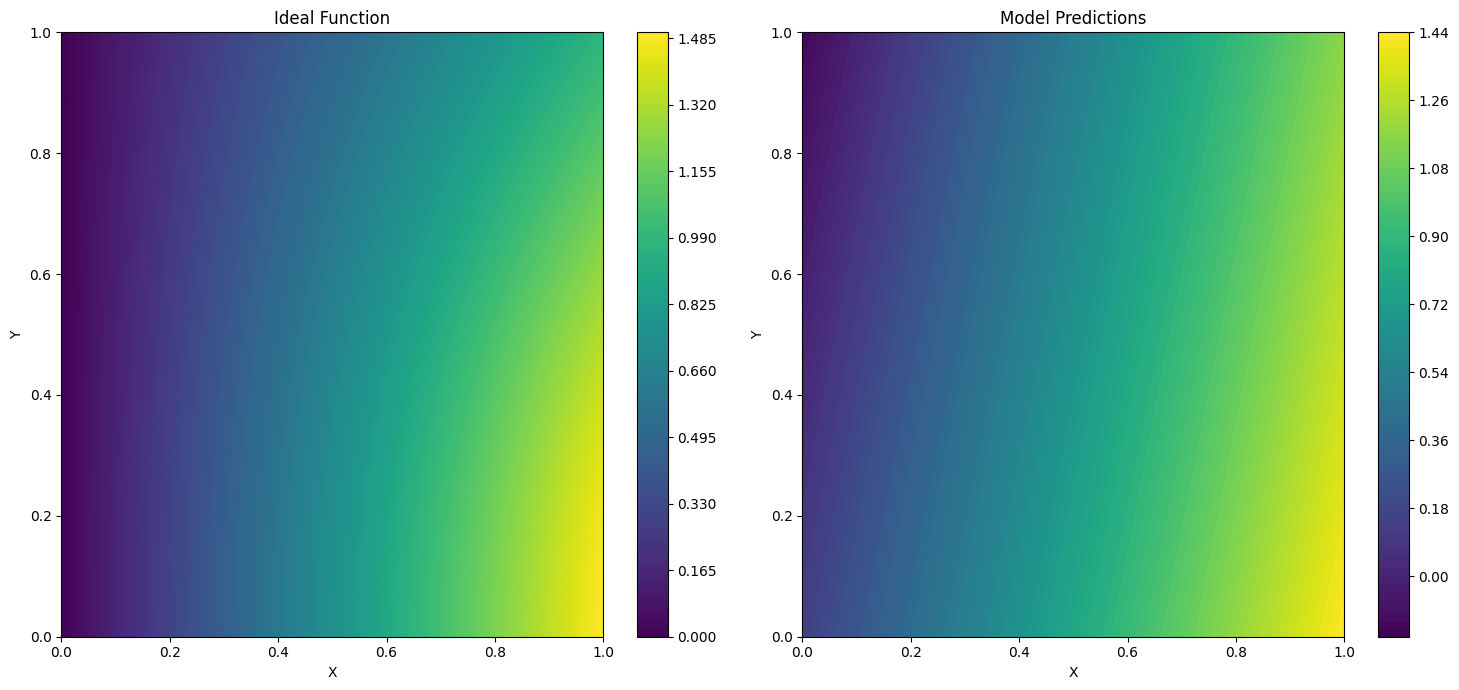

Training time: 72.26965899599963, mse: 0.002794013122377692, r2: 0.9824781783752362


In [13]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(dataset, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [14]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

Quantum Annealing Metrics:
Total run time in seconds: 4.032177162000449
MSE: 0.0031, r2: 0.9803
Simulated Annealing Metrics
Total run time in seconds: 14.029242445000818
MSE: 0.0031, r2: 0.9803
Adam Optimizer Metrics
Total run time in seconds: 72.16724453000006
MSE: 0.0028, r2: 0.9822
SGD Optimizer Metrics
Total run time in seconds: 71.21353072500006
MSE: 0.0028, r2: 0.9825
AdaGrad Optimizer Metrics
Total run time in seconds: 72.26965899599963
MSE: 0.0028, r2: 0.9825


# Now lets add a few more datapoints to make dataset 2

In [15]:
dataset_1 = dataset
X_1 = X
y_1 = 1
x_data_1 = x_data
y_data_1 = y_data
z_data_1 = z_data

In [16]:
dataset = dataset_split1
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [17]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file2, load_filename=save_file1
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [18]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.22708298199995625


In [19]:
# Combine datasets
combined_train_input = torch.cat((dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_2 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_access_time: 89926 microseconds
charge_time: 2999978 microseconds
run_time: 2999978 microseconds
problem_id: 0906b313-8bcf-44b4-b95a-b6cb527b2a38 microseconds

QPU Access Time: 89926 microseconds

Total D-Wave Run Time Including Setup: 2999978 microseconds
Time spent on hybrid part 2: 2.999978
Time spent on part 3: 0.0005053860004409216
Time spent on optimization: 3.227566368000397
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33:

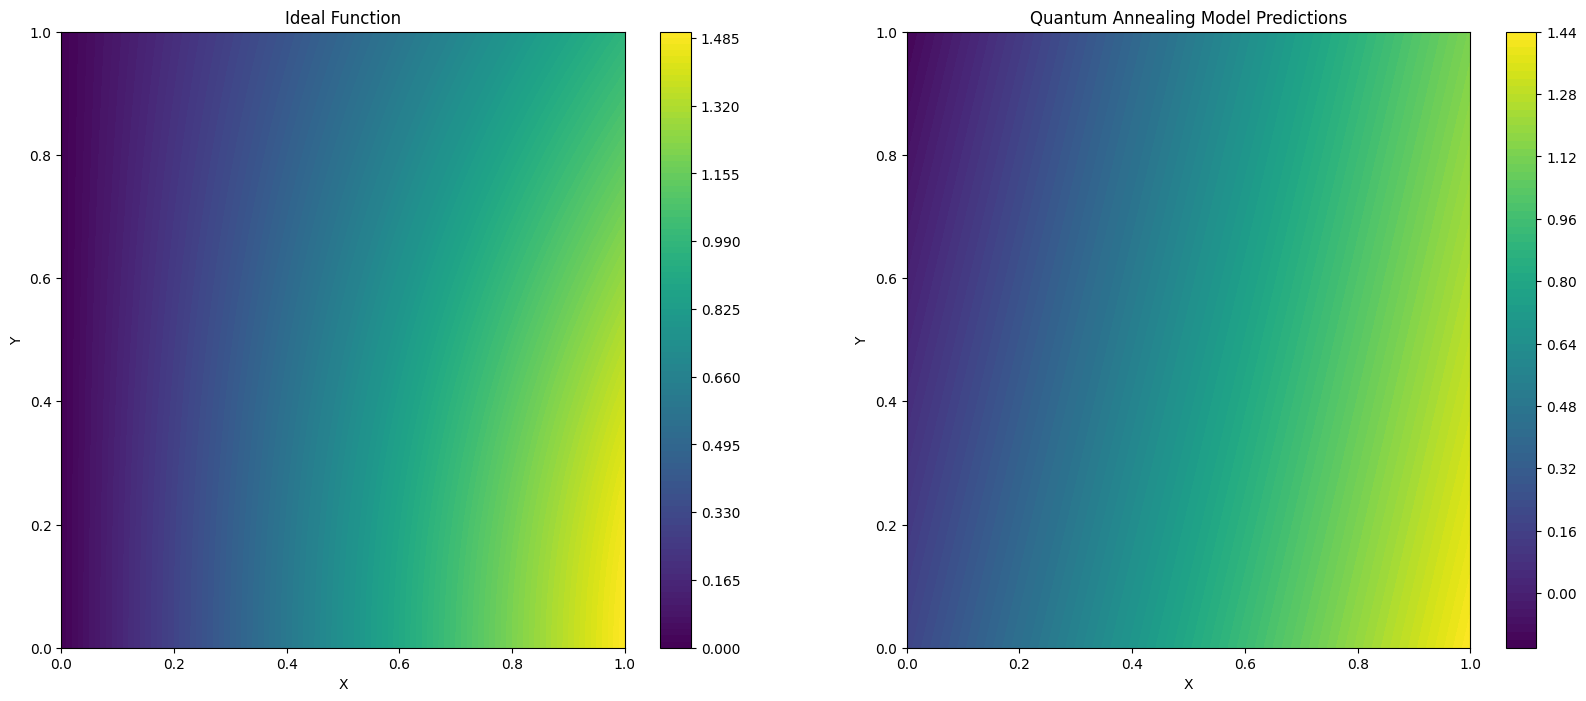

In [20]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 13.020201278000059
Time spent on part 3: 0.0014326500004244735
Time spent on optimization: 13.24871691000044
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.0, 0.25]
optimized_coefficients_3: [1.5, 0.25]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: C

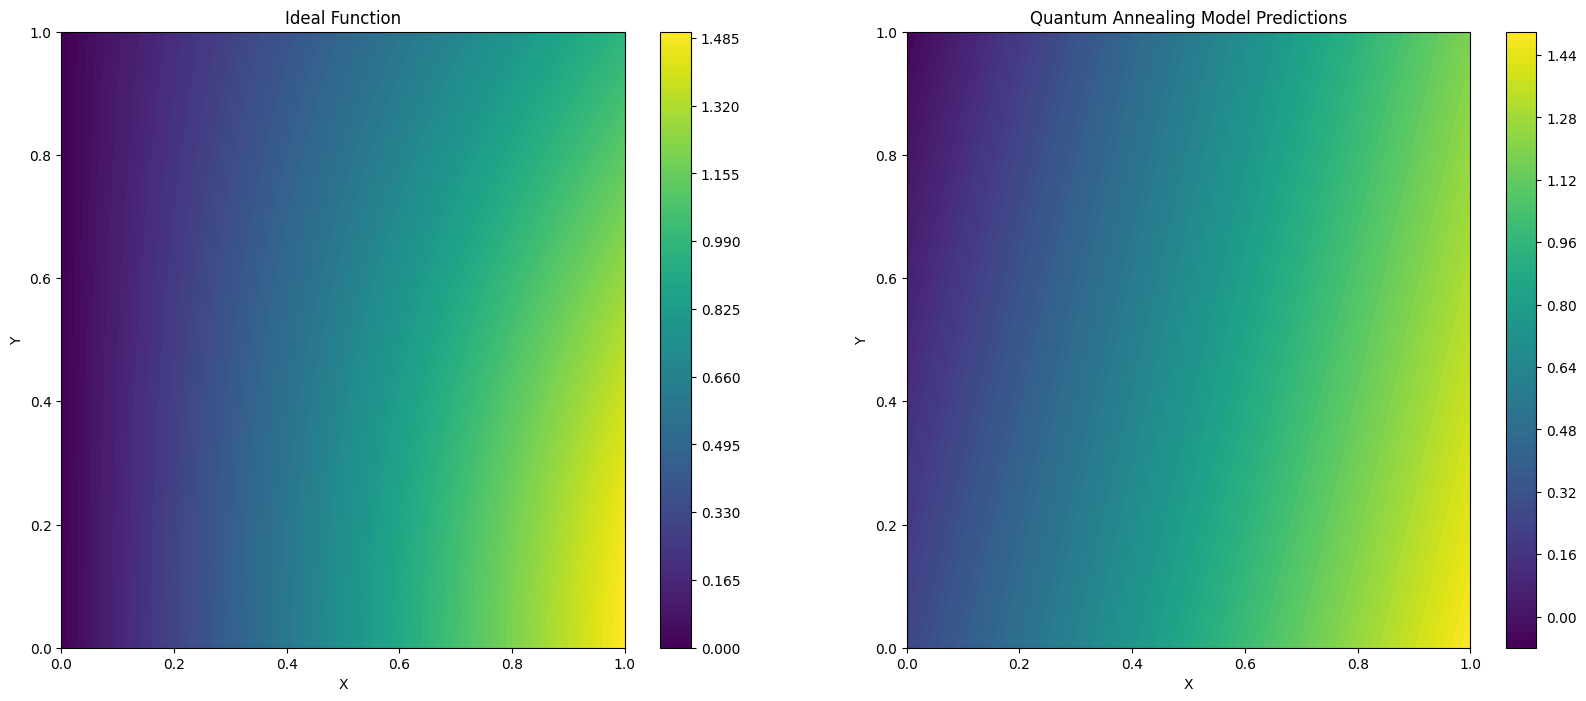

In [21]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.21e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:14<00:00,  1.04s/it]


Training time in seconds of lr=0.05: 74.85159408399977
Learning Rate: 0.05, Train MSE: 0.0029715334781591895, Train r2: 0.9813649123050607


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:14<00:00,  1.03s/it]


Training time in seconds of lr=0.1: 74.42146524300006
Learning Rate: 0.1, Train MSE: 0.0029366671356470518, Train r2: 0.9815835661937318


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.52e+00 : 100%|███████| 72/72 [01:15<00:00,  1.05s/it]


Training time in seconds of lr=0.2: 75.9615851640001
Learning Rate: 0.2, Train MSE: 0.0028501334439934864, Train r2: 0.9821262364831238
Best Learning Rate: 0.2 with Train MSE: 0.0028501334439934864


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.51e+00 : 100%|███████| 72/72 [01:14<00:00,  1.04s/it]


Training time in seconds: 74.71706445099971
Layer 0 Bezier coefficients:
[[ 1.425645   -2.013071  ]
 [-0.7808343   0.94418997]]
Layer 1 Bezier coefficients:
[[0.75757694 0.22973669]]


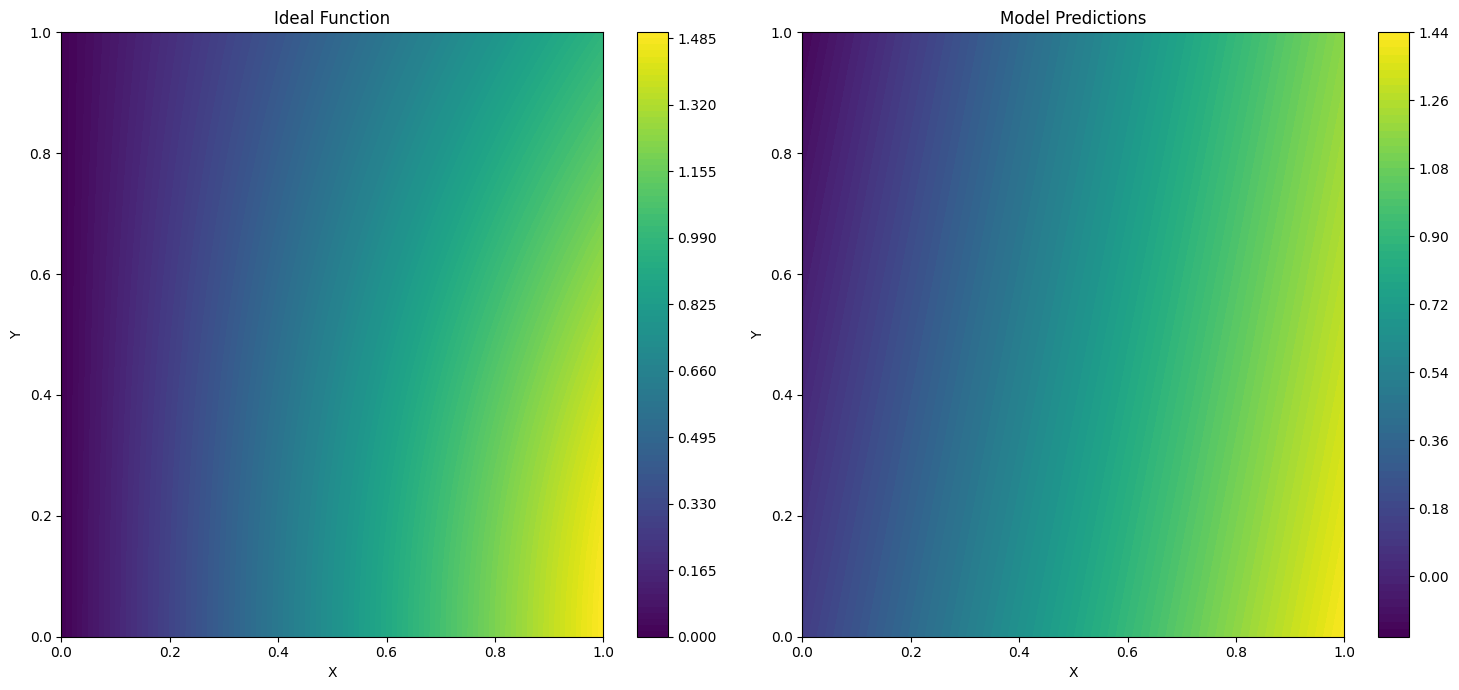

Training time: 74.71706445099971, mse: 0.002847915246945815, r2: 0.9821401472456348


In [22]:
# Change the learning rates to be in a narrower range where we saw optimal lrs in round 1.
learning_rates = [0.05, 0.1, 0.2]
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_2, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.81e-01 | test loss: nan | reg: 2.61e+00 : 100%|███████| 72/72 [01:13<00:00,  1.02s/it]


Training time in seconds of lr=0.05: 73.40158006599995
Learning Rate: 0.05, Train MSE: 0.03101173509509739, Train r2: 0.8055191343738901


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:14<00:00,  1.04s/it]


Training time in seconds of lr=0.1: 74.64877863299989
Learning Rate: 0.1, Train MSE: 0.0028531839974931927, Train r2: 0.982107105844885


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:13<00:00,  1.02s/it]


Training time in seconds of lr=0.2: 73.41655050600002
Learning Rate: 0.2, Train MSE: 0.002793839902675988, Train r2: 0.9824792646710345
Best Learning Rate: 0.2 with Train MSE: 0.002793839902675988


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:14<00:00,  1.03s/it]


Training time in seconds: 74.06706322099944
Layer 0 Bezier coefficients:
[[ 0.55258816 -0.44568062]
 [-0.07892067  0.17846759]]
Layer 1 Bezier coefficients:
[[ 0.65328246 -0.24972457]]


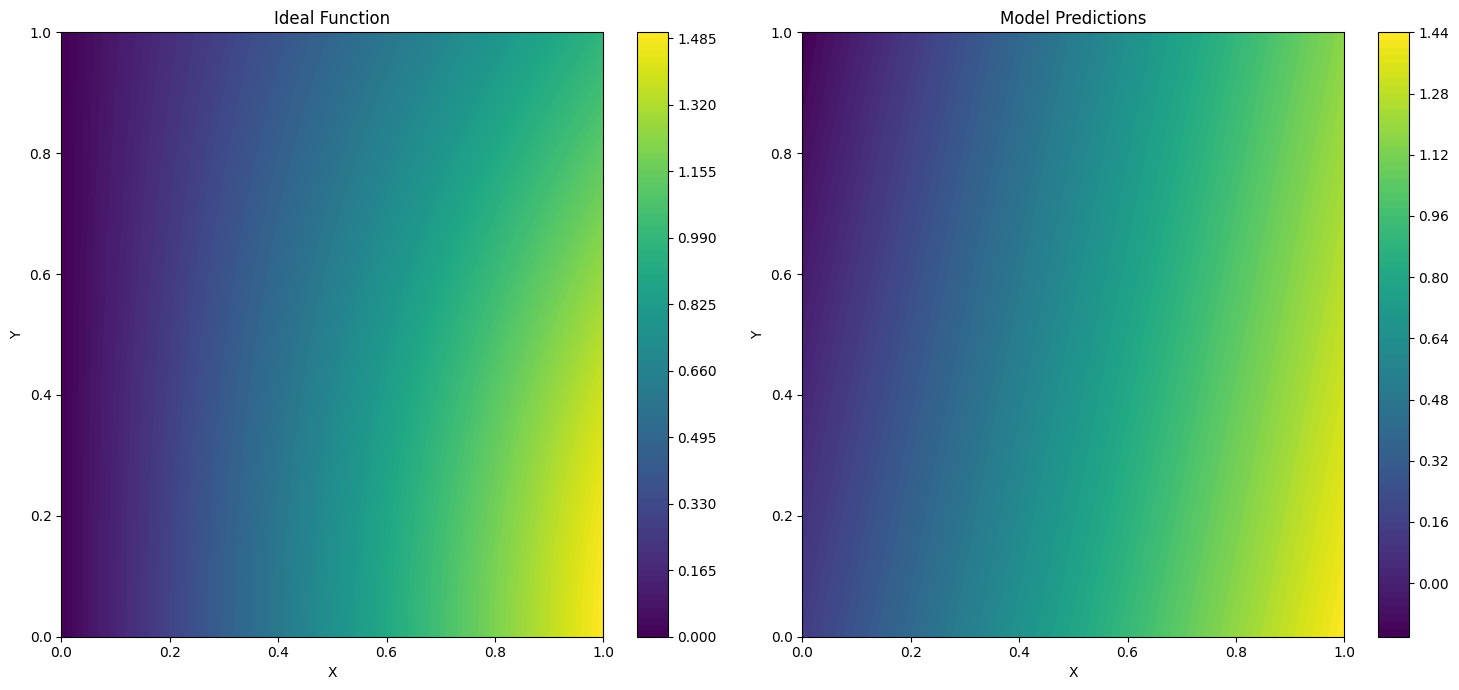

Training time: 74.06706322099944, mse: 0.0027938396889445297, r2: 0.9824792660113877


In [23]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_2, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.14e-02 | test loss: nan | reg: 2.39e+00 : 100%|███████| 72/72 [01:14<00:00,  1.03s/it]


Training time in seconds of lr=0.05: 74.51567432400043
Learning Rate: 0.05, Train MSE: 0.0029049743482976098, Train r2: 0.9817823180758474


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:14<00:00,  1.03s/it]


Training time in seconds of lr=0.1: 74.49781143400014
Learning Rate: 0.1, Train MSE: 0.0027939858488335665, Train r2: 0.9824783494131499


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.18e+00 : 100%|███████| 72/72 [01:17<00:00,  1.07s/it]


Training time in seconds of lr=0.2: 77.35164431500016
Learning Rate: 0.2, Train MSE: 0.0027975826836007522, Train r2: 0.9824557929345494
Best Learning Rate: 0.1 with Train MSE: 0.0027939858488335665


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:14<00:00,  1.04s/it]


Training time in seconds: 74.74926717699964
Layer 0 Bezier coefficients:
[[ 0.42816916 -0.6474011 ]
 [-0.2360905   0.15870342]]
Layer 1 Bezier coefficients:
[[ 0.3505001  -0.14854904]]


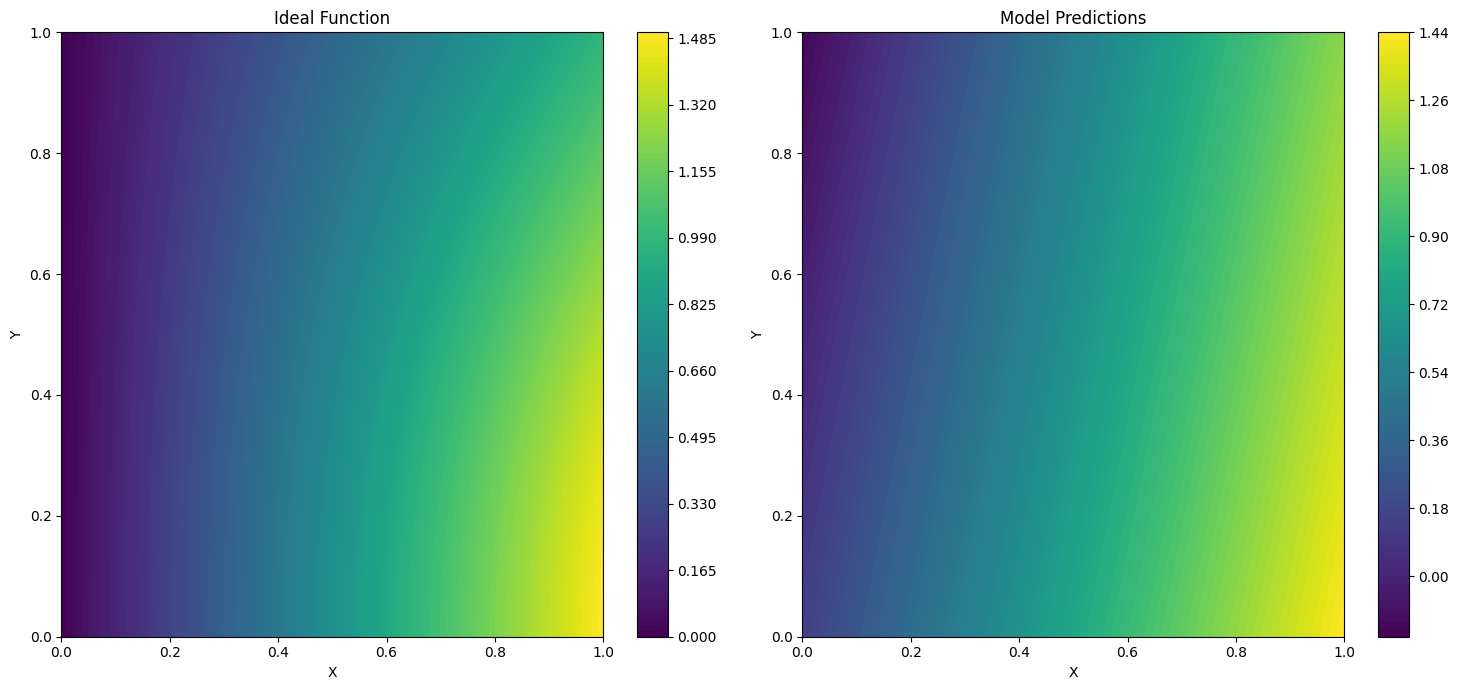

Training time: 74.74926717699964, mse: 0.0027939853961433327, r2: 0.9824783522520619


In [24]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_2, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [25]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 3.227566368000397
MSE: 0.0031, r2: 0.9803
Simulated Annealing Metrics
Total run time in seconds: 13.24871691000044
MSE: 0.0081, r2: 0.9495
Adam Optimizer Metrics
Total run time in seconds: 74.71706445099971
MSE: 0.0028, r2: 0.9821
SGD Optimizer Metrics
Total run time in seconds: 74.06706322099944
MSE: 0.0028, r2: 0.9825
AdaGrad Optimizer Metrics
Total run time in seconds: 74.74926717699964
MSE: 0.0028, r2: 0.9825
Array of time for quantum in each training/retraining: [4.032177162000449, 3.227566368000397], total time: 7.259743530000847
Array of time for simulated in each training/retraining: [14.029242445000818, 13.24871691000044], total time: 27.277959355001258
Array of time for adam in each training/retraining: [72.16724453000006, 74.71706445099971], total time: 146.88430898099978
Array of time for SDG in each training/retraining: [71.21353072500006, 74.06706322099944], total time: 145.2805939459995
Array of time for adagrad in ea

# Adding a few more datapoints to make dataset 3

In [26]:
dataset_2 = dataset
X_2 = X
y_2 = 1
x_data_2 = x_data
y_data_2 = y_data
z_data_2 = z_data

In [27]:
dataset = dataset_split2
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [28]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file3, load_filename=save_file2
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [29]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.251969934999579


In [30]:
# Combine datasets
combined_train_input = torch.cat((dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_3 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_access_time: 134767 microseconds
charge_time: 2994623 microseconds
run_time: 2994623 microseconds
problem_id: a0b13eed-ae30-4382-87d0-8e666f81c89e microseconds

QPU Access Time: 134767 microseconds

Total D-Wave Run Time Including Setup: 2994623 microseconds
Time spent on hybrid part 2: 2.994623
Time spent on part 3: 0.0004784579996339744
Time spent on optimization: 3.2470713929992128
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX

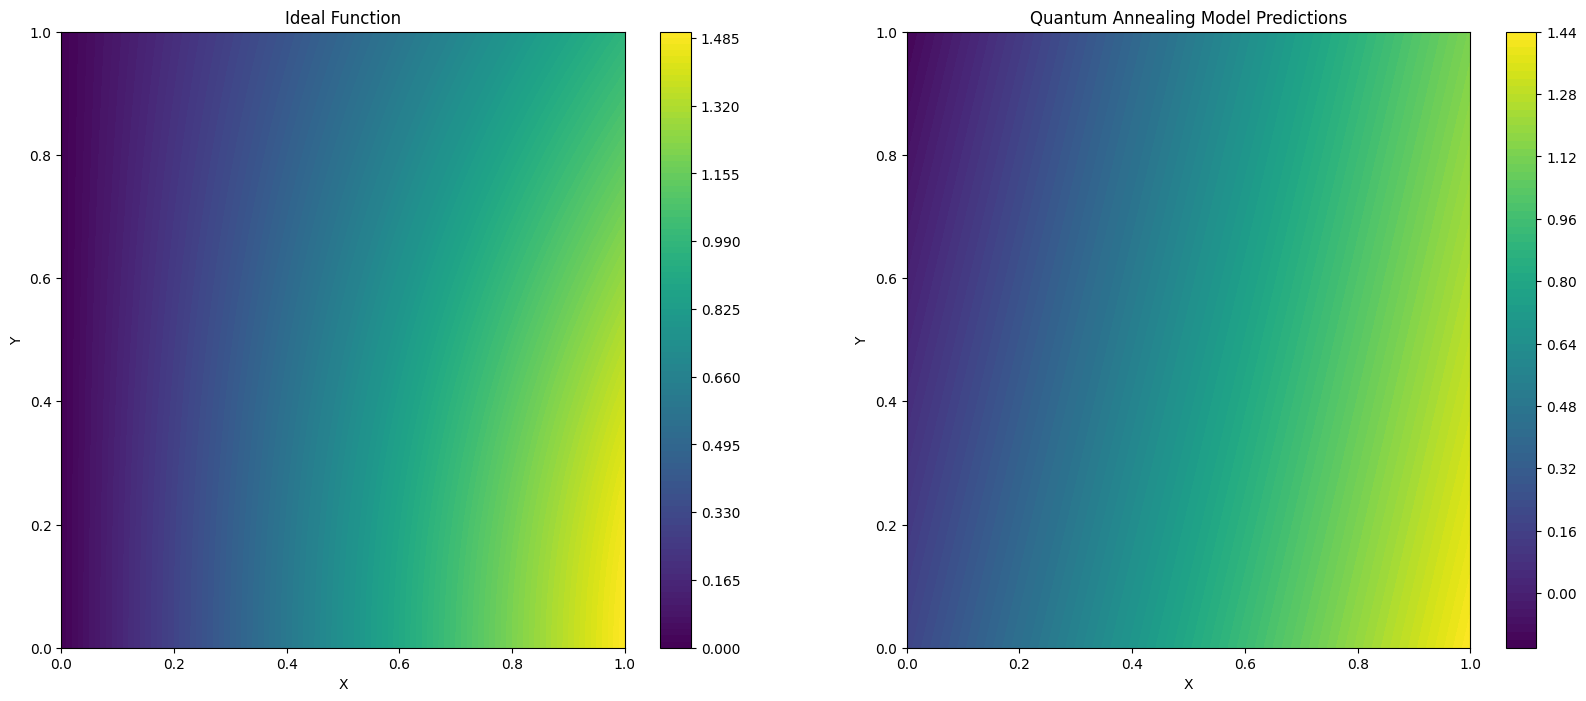

In [31]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 13.404743911999503
Time spent on part 3: 0.0014943080004741205
Time spent on optimization: 13.658208154999556
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.0, 0.25]
optimized_coefficients_3: [1.5, 0.25]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: 

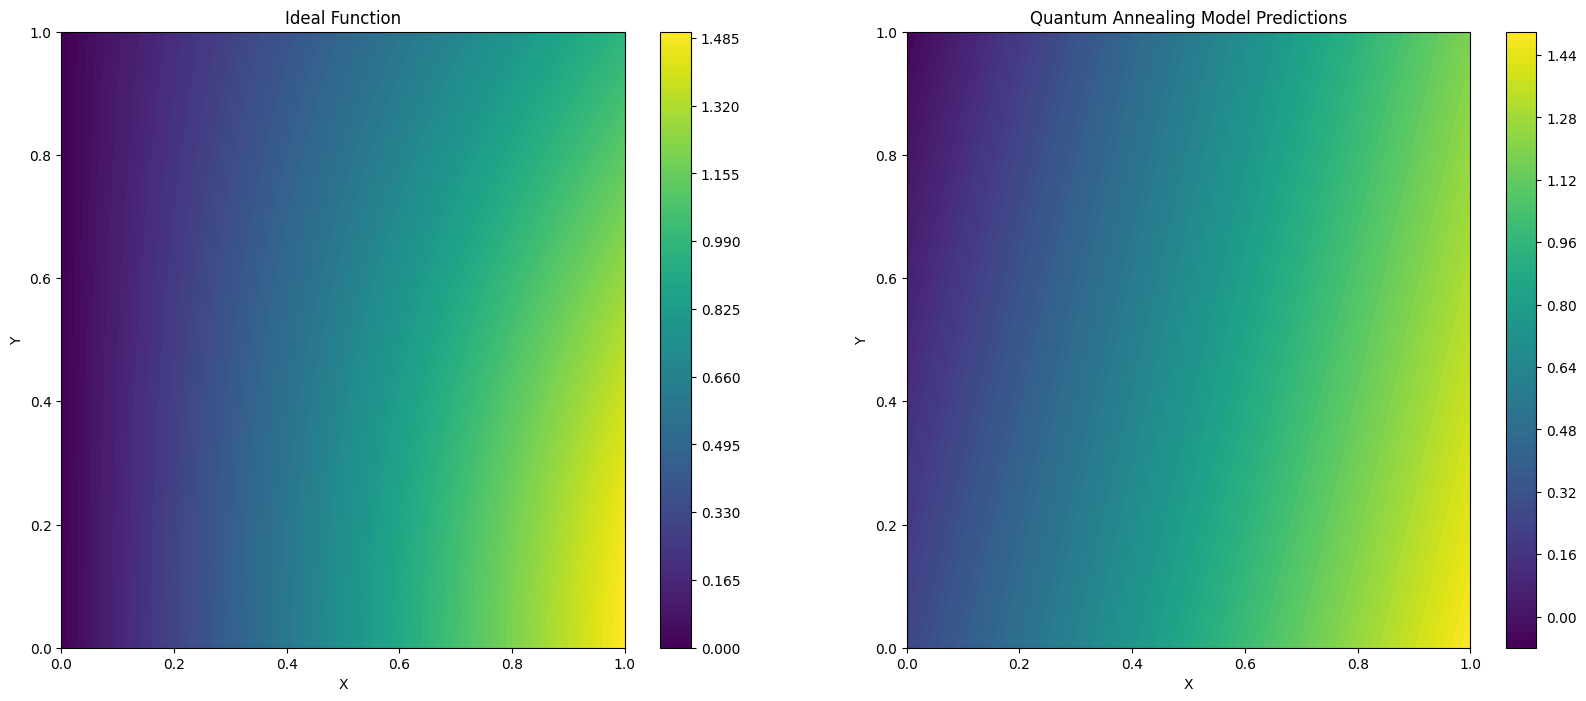

In [32]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.19e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:20<00:00,  1.12s/it]


Training time in seconds of lr=0.05: 80.55483234199983
Learning Rate: 0.05, Train MSE: 0.0029609423264134885, Train r2: 0.9814313315606479


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:20<00:00,  1.12s/it]


Training time in seconds of lr=0.1: 80.623714372
Learning Rate: 0.1, Train MSE: 0.0029265436681489266, Train r2: 0.9816470525067721


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.52e+00 : 100%|███████| 72/72 [01:20<00:00,  1.12s/it]


Training time in seconds of lr=0.2: 80.9703274200001
Learning Rate: 0.2, Train MSE: 0.0028507757487462528, Train r2: 0.9821222084600567
Best Learning Rate: 0.2 with Train MSE: 0.0028507757487462528


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.07e-02 | test loss: nan | reg: 2.51e+00 : 100%|███████| 72/72 [01:21<00:00,  1.13s/it]


Training time in seconds: 81.03533444499953
Layer 0 Bezier coefficients:
[[ 1.4279398 -2.0145693]
 [-0.7773276  0.9447725]]
Layer 1 Bezier coefficients:
[[0.7543046  0.22818013]]


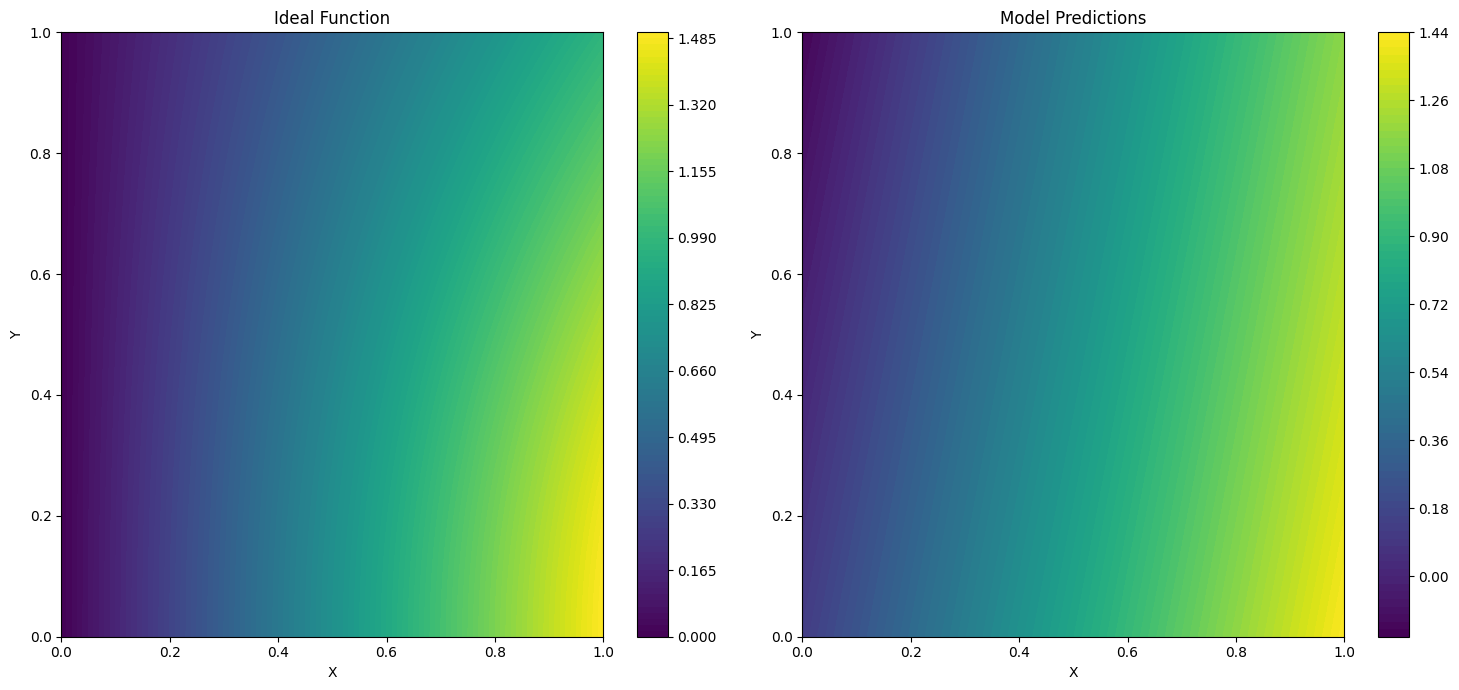

Training time: 81.03533444499953, mse: 0.002845222016222726, r2: 0.9821570370404415


In [33]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_3, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.81e-01 | test loss: nan | reg: 2.61e+00 : 100%|███████| 72/72 [01:19<00:00,  1.11s/it]


Training time in seconds of lr=0.05: 79.89570847699997
Learning Rate: 0.05, Train MSE: 0.031099848640578173, Train r2: 0.8049665565014834


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:19<00:00,  1.11s/it]


Training time in seconds of lr=0.1: 79.89545909199933
Learning Rate: 0.1, Train MSE: 0.0028538743030491315, Train r2: 0.9821027767990689


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:22<00:00,  1.15s/it]


Training time in seconds of lr=0.2: 82.47478039500038
Learning Rate: 0.2, Train MSE: 0.0027938528349045607, Train r2: 0.9824791835704124
Best Learning Rate: 0.2 with Train MSE: 0.0027938528349045607


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:22<00:00,  1.15s/it]


Training time in seconds: 82.58598483700007
Layer 0 Bezier coefficients:
[[ 0.55255777 -0.44569   ]
 [-0.07892288  0.17844136]]
Layer 1 Bezier coefficients:
[[ 0.6531835  -0.24973598]]


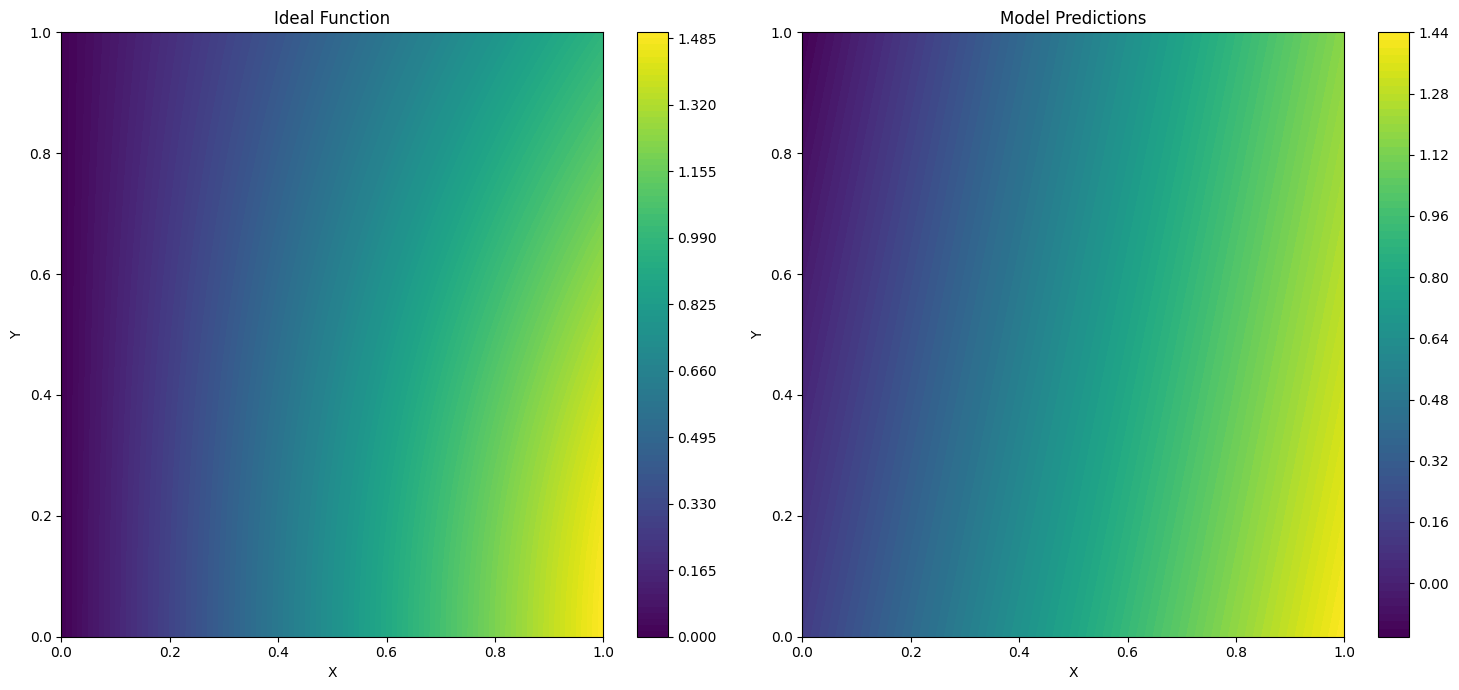

Training time: 82.58598483700007, mse: 0.0027938527116966663, r2: 0.982479184343074


In [34]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_3, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.14e-02 | test loss: nan | reg: 2.39e+00 : 100%|███████| 72/72 [01:22<00:00,  1.14s/it]


Training time in seconds of lr=0.05: 82.41450318200077
Learning Rate: 0.05, Train MSE: 0.0029055013047061787, Train r2: 0.9817790134255862


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:21<00:00,  1.13s/it]


Training time in seconds of lr=0.1: 81.35978577200149
Learning Rate: 0.1, Train MSE: 0.0027939942525273495, Train r2: 0.9824782967118858


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:20<00:00,  1.12s/it]


Training time in seconds of lr=0.2: 80.6669201679997
Learning Rate: 0.2, Train MSE: 0.0027940810555342407, Train r2: 0.982477752352666
Best Learning Rate: 0.1 with Train MSE: 0.0027939942525273495


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:21<00:00,  1.13s/it]


Training time in seconds: 81.15964308700131
Layer 0 Bezier coefficients:
[[ 0.42801508 -0.6469009 ]
 [-0.23614506  0.15851113]]
Layer 1 Bezier coefficients:
[[ 0.3504009  -0.14861508]]


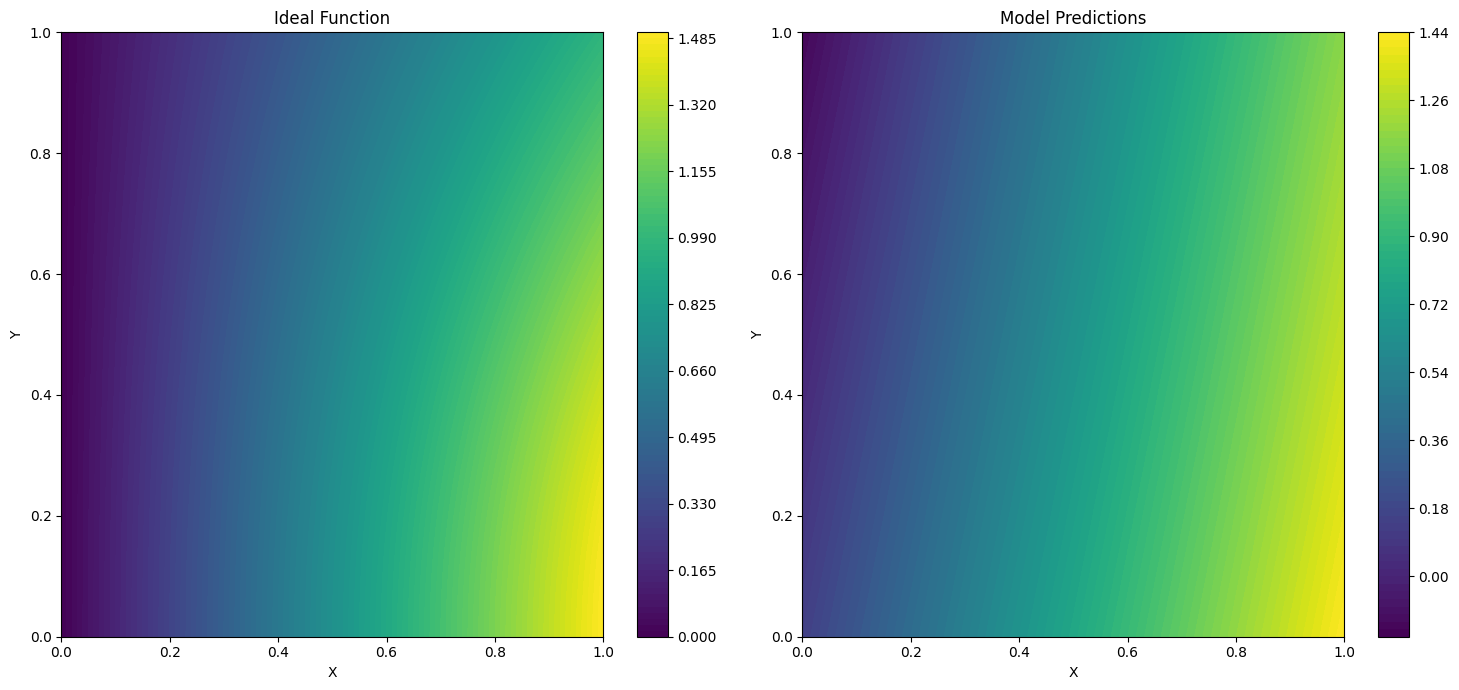

Training time: 81.15964308700131, mse: 0.0027939941728990798, r2: 0.9824782972112508


In [35]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_3, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [36]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 3.2470713929992128
MSE: 0.0031, r2: 0.9803
Simulated Annealing Metrics
Total run time in seconds: 13.658208154999556
MSE: 0.0081, r2: 0.9495
Adam Optimizer Metrics
Total run time in seconds: 81.03533444499953
MSE: 0.0028, r2: 0.9822
SGD Optimizer Metrics
Total run time in seconds: 82.58598483700007
MSE: 0.0028, r2: 0.9825
AdaGrad Optimizer Metrics
Total run time in seconds: 81.15964308700131
MSE: 0.0028, r2: 0.9825
Array of time for quantum in each training/retraining: [4.032177162000449, 3.227566368000397, 3.2470713929992128], total time: 10.50681492300006
Array of time for simulated in each training/retraining: [14.029242445000818, 13.24871691000044, 13.658208154999556], total time: 40.936167510000814
Array of time for adam in each training/retraining: [72.16724453000006, 74.71706445099971, 81.03533444499953], total time: 227.9196434259993
Array of time for SDG in each training/retraining: [71.21353072500006, 74.06706322099944, 82

# Adding a few more datapoints for dataset 4

In [37]:
dataset_3 = dataset
X_3 = X
y_3 = 1
x_data_3 = x_data
y_data_3 = y_data
z_data_3 = z_data

In [38]:
dataset = dataset_split3
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [39]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file4, load_filename=save_file3
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [40]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.25996958399991854


In [41]:
# Combine datasets
combined_train_input = torch.cat((dataset_3['train_input'], dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_3['train_label'], dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_3['test_input'], dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_3['test_label'], dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_4 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_access_time: 146270 microseconds
charge_time: 2993023 microseconds
run_time: 2993023 microseconds
problem_id: c6b67664-57bd-421b-a880-70607d7b8aea microseconds

QPU Access Time: 146270 microseconds

Total D-Wave Run Time Including Setup: 2993023 microseconds
Time spent on hybrid part 2: 2.993023
Time spent on part 3: 0.0006851250000181608
Time spent on optimization: 3.2536777089999367
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.0, 0.25]
optimized_coefficients_3: [1.5, 0.25]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX

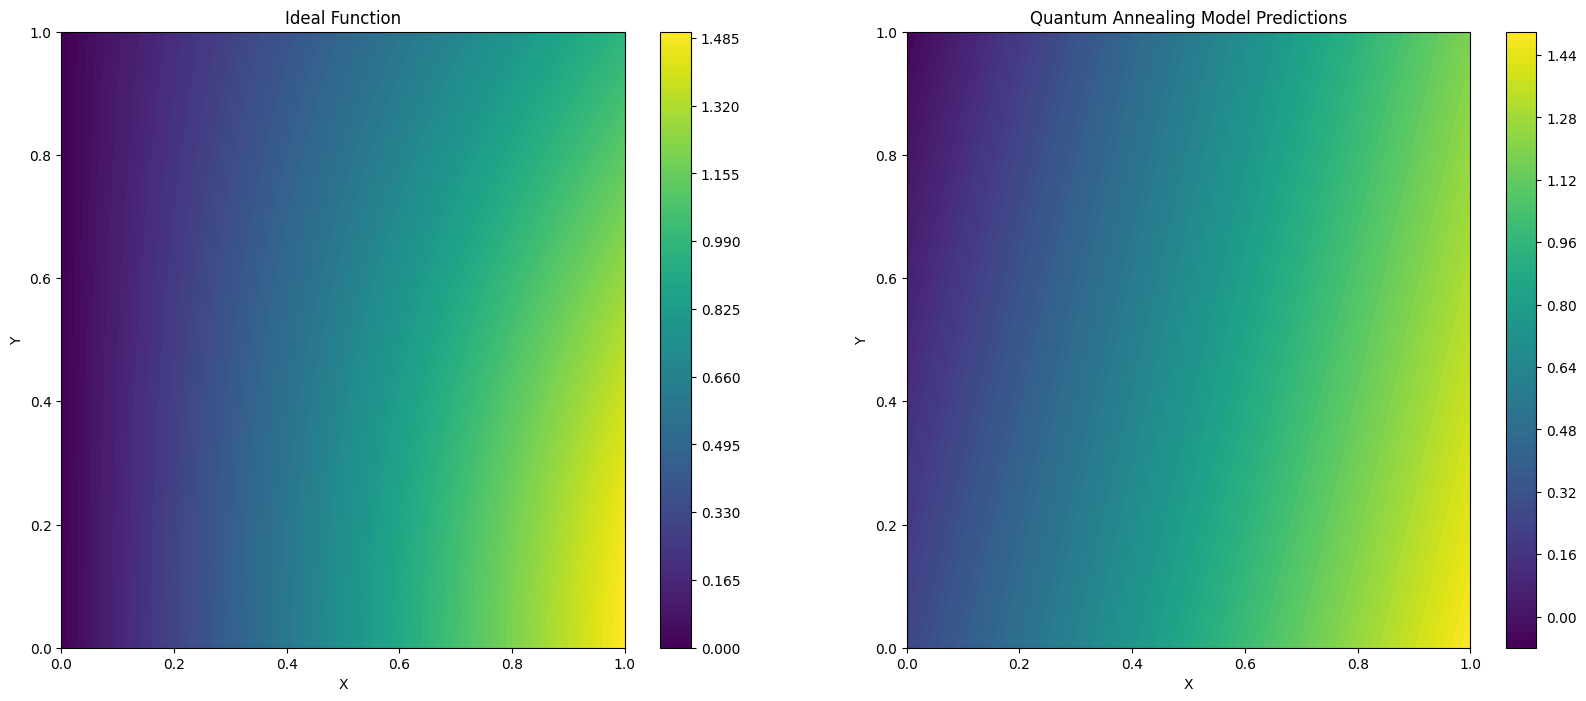

In [42]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 13.152998937999655
Time spent on part 3: 0.0013987059992359718
Time spent on optimization: 13.41436722799881
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.25]
optimized_coefficients_3: [1.5, 0.25]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: 

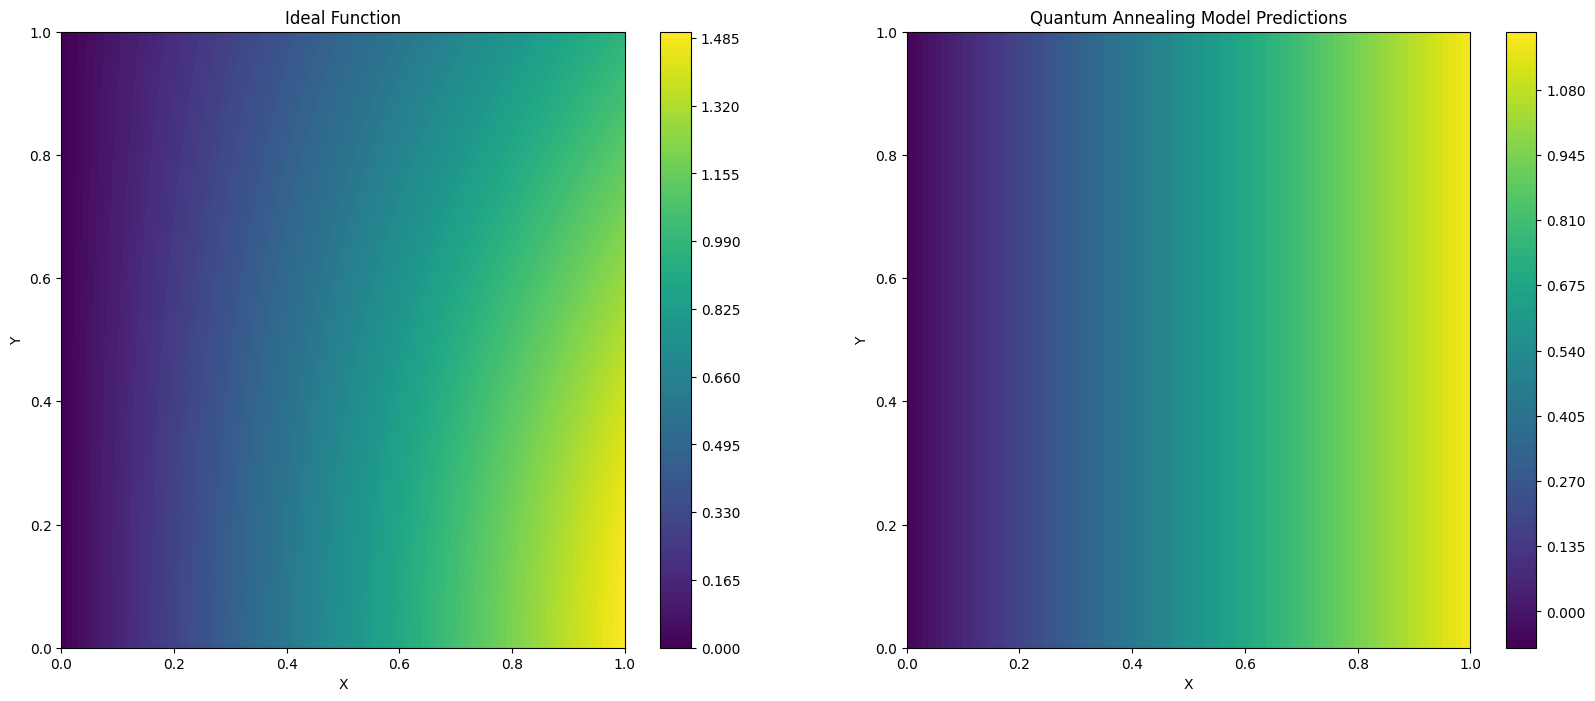

In [43]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.22e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:24<00:00,  1.17s/it]


Training time in seconds of lr=0.05: 84.26920869199967
Learning Rate: 0.05, Train MSE: 0.003001336313655661, Train r2: 0.9811780126934236


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:26<00:00,  1.20s/it]


Training time in seconds of lr=0.1: 86.47513150499981
Learning Rate: 0.1, Train MSE: 0.0029396687350947133, Train r2: 0.9815647425562586


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.51e+00 : 100%|███████| 72/72 [01:24<00:00,  1.18s/it]


Training time in seconds of lr=0.2: 84.95046801699937
Learning Rate: 0.2, Train MSE: 0.002842560482278006, Train r2: 0.9821737280583377
Best Learning Rate: 0.2 with Train MSE: 0.002842560482278006


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.51e+00 : 100%|███████| 72/72 [01:25<00:00,  1.18s/it]


Training time in seconds: 85.29869635200157
Layer 0 Bezier coefficients:
[[ 1.4289078 -2.0002694]
 [-0.7804353  0.9388622]]
Layer 1 Bezier coefficients:
[[0.75616026 0.22742212]]


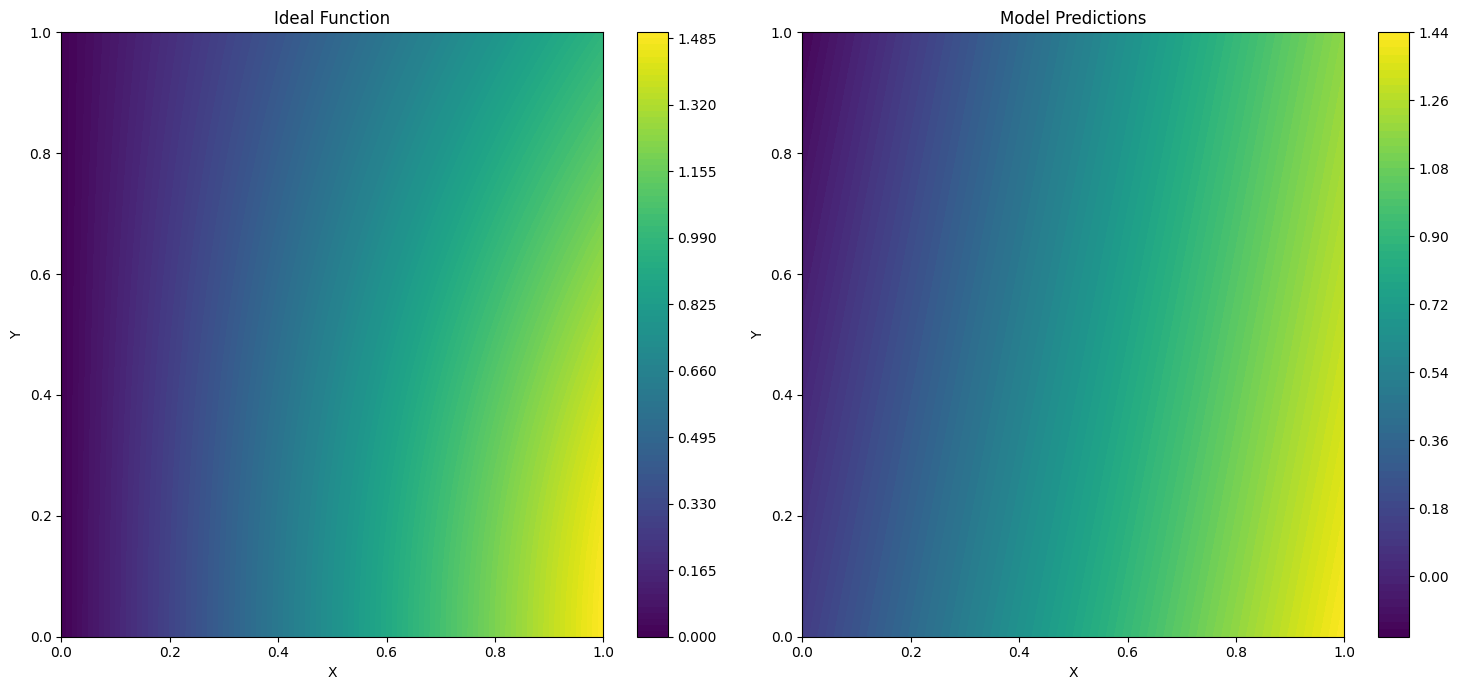

Training time: 85.29869635200157, mse: 0.002842966251797235, r2: 0.9821711833955801


In [44]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_4, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.81e-01 | test loss: nan | reg: 2.61e+00 : 100%|███████| 72/72 [01:24<00:00,  1.17s/it]


Training time in seconds of lr=0.05: 84.02653326099971
Learning Rate: 0.05, Train MSE: 0.031197177269822258, Train r2: 0.8043561889742378


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.08e-02 | test loss: nan | reg: 2.28e+00 : 100%|███████| 72/72 [01:24<00:00,  1.17s/it]


Training time in seconds of lr=0.1: 84.48283951099984
Learning Rate: 0.1, Train MSE: 0.0028756103063417716, Train r2: 0.9819664659244067


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:24<00:00,  1.17s/it]


Training time in seconds of lr=0.2: 84.59719844999927
Learning Rate: 0.2, Train MSE: 0.002793856800222566, Train r2: 0.9824791587031009
Best Learning Rate: 0.2 with Train MSE: 0.002793856800222566


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:25<00:00,  1.18s/it]


Training time in seconds: 85.07811317800042
Layer 0 Bezier coefficients:
[[ 0.5524178  -0.44588578]
 [-0.07908668  0.17829815]]
Layer 1 Bezier coefficients:
[[ 0.65272796 -0.24993418]]


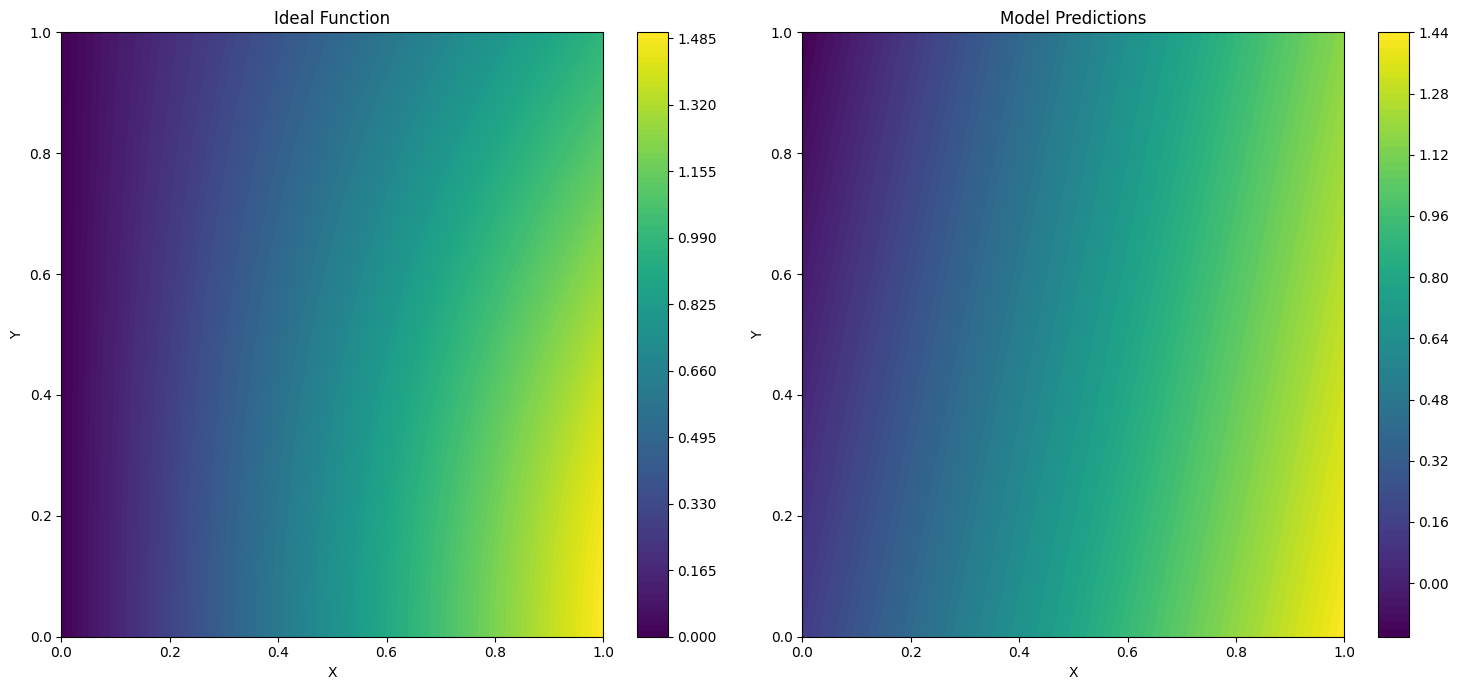

Training time: 85.07811317800042, mse: 0.0027938571047189924, r2: 0.9824791567935421


In [45]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_4, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.13e-02 | test loss: nan | reg: 2.39e+00 : 100%|███████| 72/72 [01:23<00:00,  1.16s/it]


Training time in seconds of lr=0.05: 83.81707577199995
Learning Rate: 0.05, Train MSE: 0.002903757625394985, Train r2: 0.9817899483913588


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.20e+00 : 100%|███████| 72/72 [01:25<00:00,  1.19s/it]


Training time in seconds of lr=0.1: 85.81979625199892
Learning Rate: 0.1, Train MSE: 0.0027939982183638966, Train r2: 0.9824782718413223


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:26<00:00,  1.20s/it]


Training time in seconds of lr=0.2: 86.41246957099975
Learning Rate: 0.2, Train MSE: 0.0027939851064650986, Train r2: 0.9824783540686928
Best Learning Rate: 0.2 with Train MSE: 0.0027939851064650986


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:24<00:00,  1.18s/it]


Training time in seconds: 84.84782207700118
Layer 0 Bezier coefficients:
[[ 0.51213956 -0.89623   ]
 [-0.17829414  0.31759238]]
Layer 1 Bezier coefficients:
[[ 0.3791626  -0.13338456]]


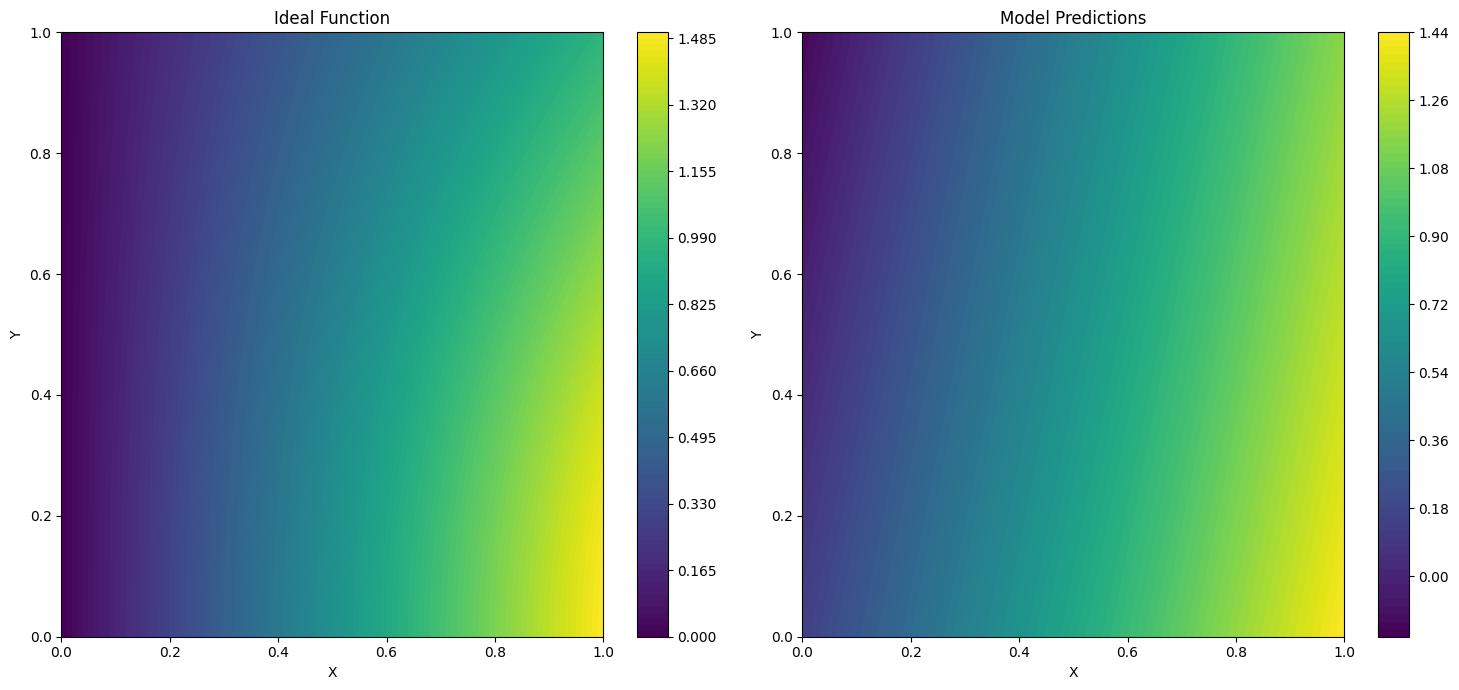

Training time: 84.84782207700118, mse: 0.0027939870990211307, r2: 0.9824783415729708


In [46]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_4, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [47]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 3.2536777089999367
MSE: 0.0081, r2: 0.9495
Simulated Annealing Metrics
Total run time in seconds: 13.41436722799881
MSE: 0.0173, r2: 0.8917
Adam Optimizer Metrics
Total run time in seconds: 85.29869635200157
MSE: 0.0028, r2: 0.9822
SGD Optimizer Metrics
Total run time in seconds: 85.07811317800042
MSE: 0.0028, r2: 0.9825
AdaGrad Optimizer Metrics
Total run time in seconds: 84.84782207700118
MSE: 0.0028, r2: 0.9825
Array of time for quantum in each training/retraining: [4.032177162000449, 3.227566368000397, 3.2470713929992128, 3.2536777089999367], total time: 13.760492631999998
Array of time for simulated in each training/retraining: [14.029242445000818, 13.24871691000044, 13.658208154999556, 13.41436722799881], total time: 54.350534737999624
Array of time for adam in each training/retraining: [72.16724453000006, 74.71706445099971, 81.03533444499953, 85.29869635200157], total time: 313.2183397780009
Array of time for SDG in each trai

# Adding a few more datapoints for dataset 5

In [48]:
dataset_4 = dataset
X_4 = X
y_4 = 1
x_data_4 = x_data
y_data_4 = y_data
z_data_4 = z_data

In [49]:
dataset = dataset_split4
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [50]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    load_filename=save_file4
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [51]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.22514057999978832


In [52]:
# Combine datasets
combined_train_input = torch.cat((dataset_4['train_input'], dataset_3['train_input'], dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_3['train_label'], dataset_3['train_label'], dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_4['test_input'], dataset_3['test_input'], dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_4['test_label'], dataset_3['test_label'], dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_5 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_access_time: 148386 microseconds
charge_time: 2990423 microseconds
run_time: 2990423 microseconds
problem_id: bd816bed-8538-4179-9a90-44e5a9a863fe microseconds

QPU Access Time: 148386 microseconds

Total D-Wave Run Time Including Setup: 2990423 microseconds
Time spent on hybrid part 2: 2.990423
Time spent on part 3: 0.0004470069998205872
Time spent on optimization: 3.2160105869996087
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX

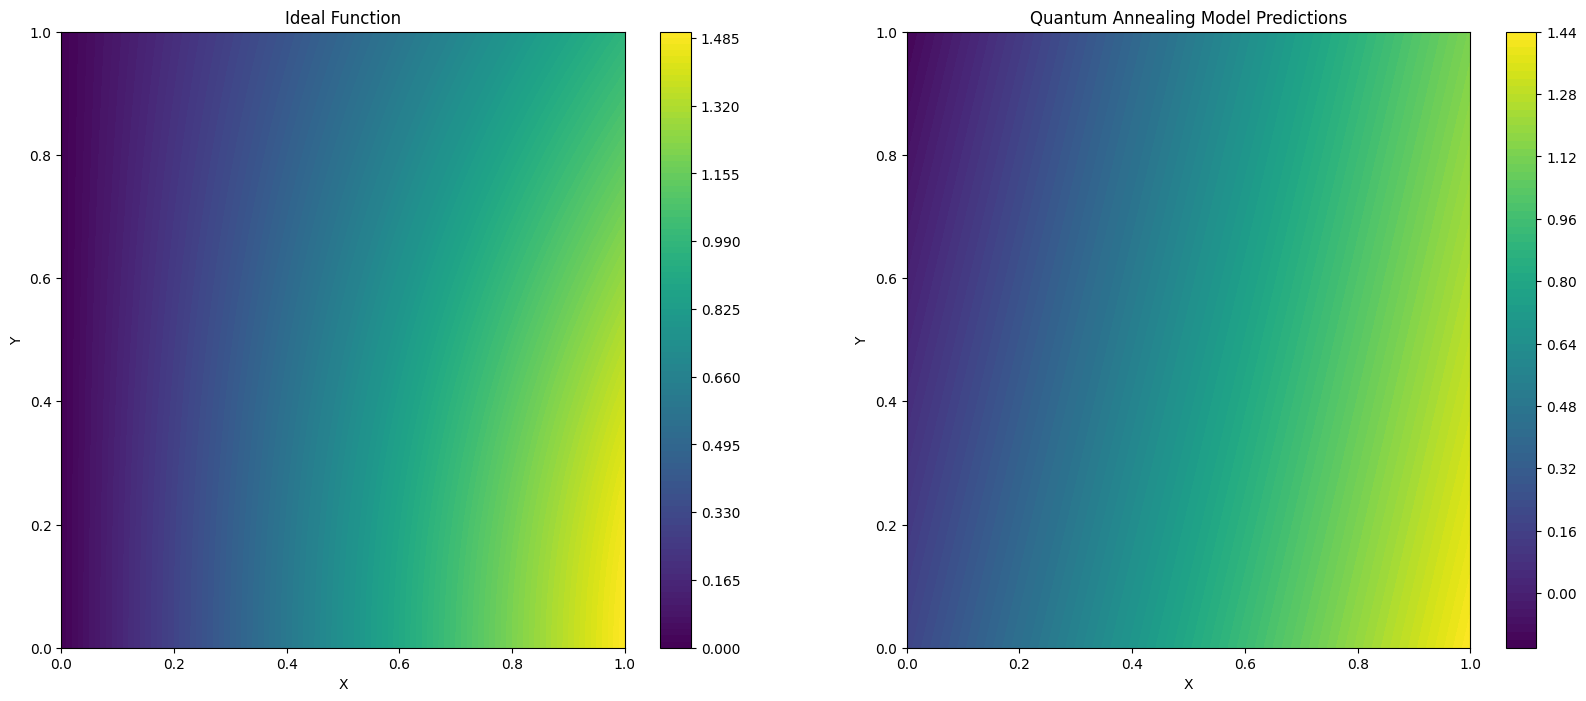

In [53]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 13.288407198000641
Time spent on part 3: 0.001452904998586746
Time spent on optimization: 13.515000682999016
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: C

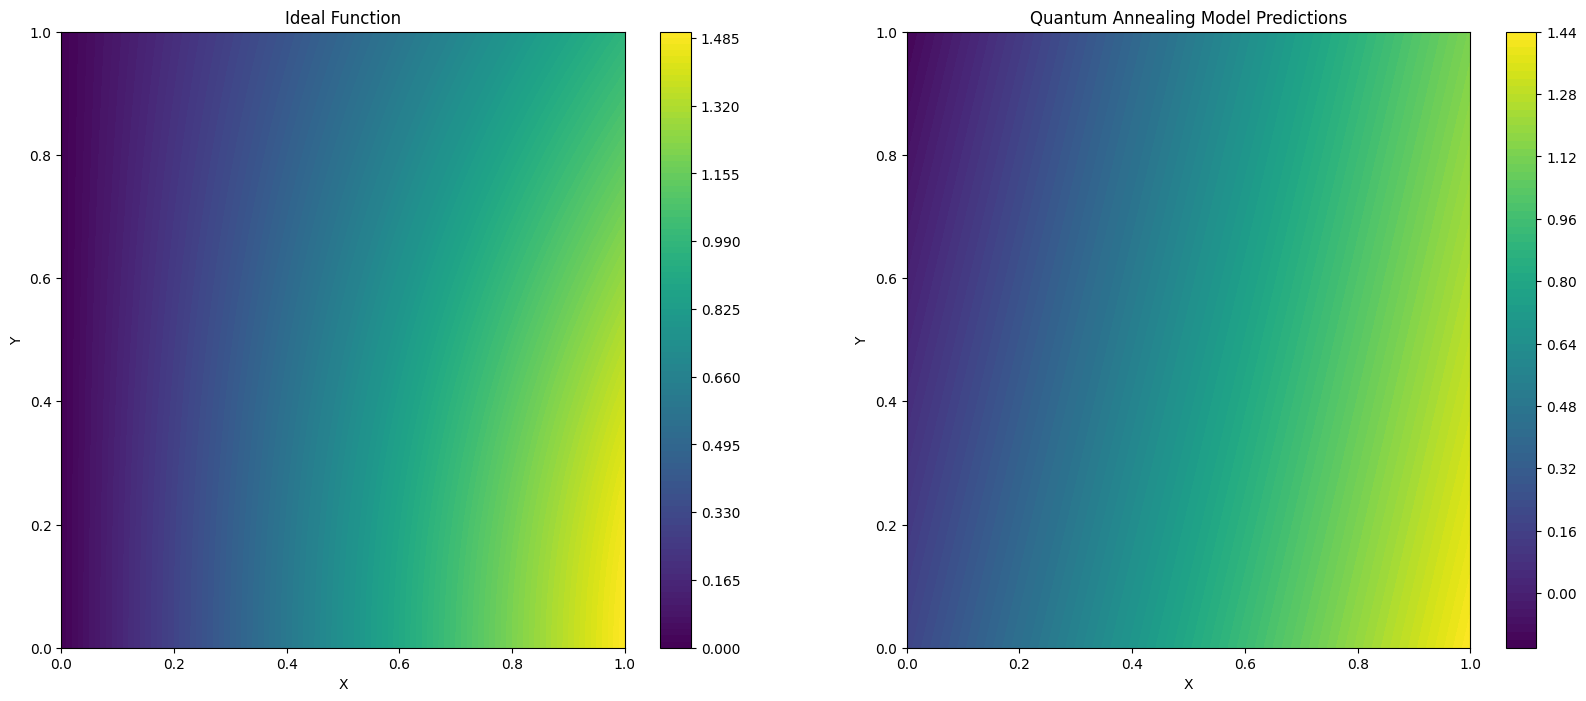

In [54]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:29<00:00,  1.25s/it]


Training time in seconds of lr=0.05: 89.72868797299998
Learning Rate: 0.05, Train MSE: 0.002805503928759795, Train r2: 0.9824061172033901


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.20e+00 : 100%|███████| 72/72 [01:28<00:00,  1.23s/it]


Training time in seconds of lr=0.1: 88.52289255400137
Learning Rate: 0.1, Train MSE: 0.003581184477258518, Train r2: 0.9775416675342964


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.49e+00 : 100%|███████| 72/72 [01:28<00:00,  1.22s/it]


Training time in seconds of lr=0.2: 88.15094078599941
Learning Rate: 0.2, Train MSE: 0.0029031471359425446, Train r2: 0.9817937768942401
Best Learning Rate: 0.05 with Train MSE: 0.002805503928759795


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:27<00:00,  1.21s/it]


Training time in seconds: 87.39930037799968
Layer 0 Bezier coefficients:
[[ 0.57847214 -0.9920927 ]
 [-0.27204314  0.31001854]]
Layer 1 Bezier coefficients:
[[ 0.44096863 -0.14636485]]


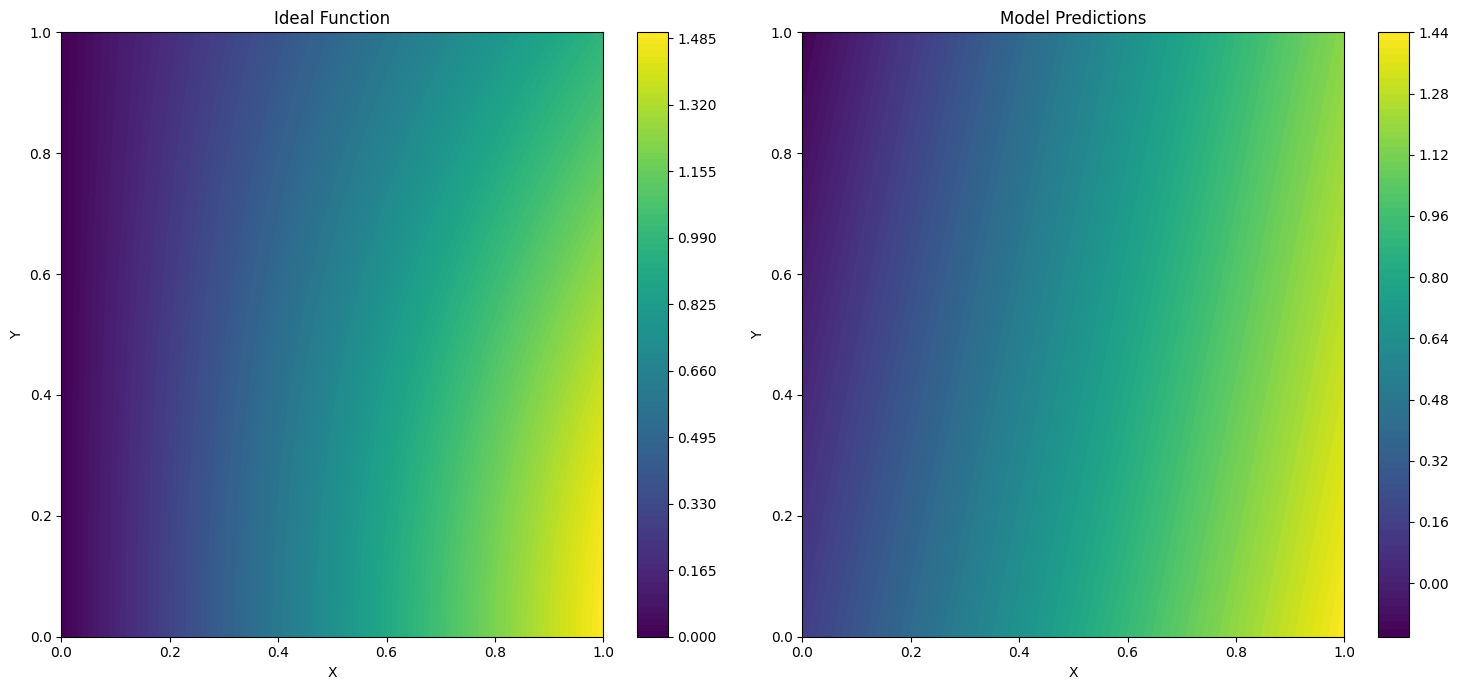

Training time: 87.39930037799968, mse: 0.002804946959443182, r2: 0.9824096100706705


In [55]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_5, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.11e-01 | test loss: nan | reg: 2.66e+00 : 100%|███████| 72/72 [01:25<00:00,  1.18s/it]


Training time in seconds of lr=0.05: 85.0235526460001
Learning Rate: 0.05, Train MSE: 0.03696704610502413, Train r2: 0.7681721740463994


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.27e+00 : 100%|███████| 72/72 [01:25<00:00,  1.18s/it]


Training time in seconds of lr=0.1: 85.04666168400036
Learning Rate: 0.1, Train MSE: 0.0033467927154649086, Train r2: 0.9790115856988062


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.25e+00 : 100%|███████| 72/72 [01:25<00:00,  1.19s/it]


Training time in seconds of lr=0.2: 85.79289165199953
Learning Rate: 0.2, Train MSE: 0.0030458171695916785, Train r2: 0.9808990642456925
Best Learning Rate: 0.2 with Train MSE: 0.0030458171695916785


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:25<00:00,  1.19s/it]


Training time in seconds: 85.61773807800091
Layer 0 Bezier coefficients:
[[ 0.56861526 -0.44801128]
 [-0.07595737  0.18706387]]
Layer 1 Bezier coefficients:
[[ 0.6609363  -0.18535584]]


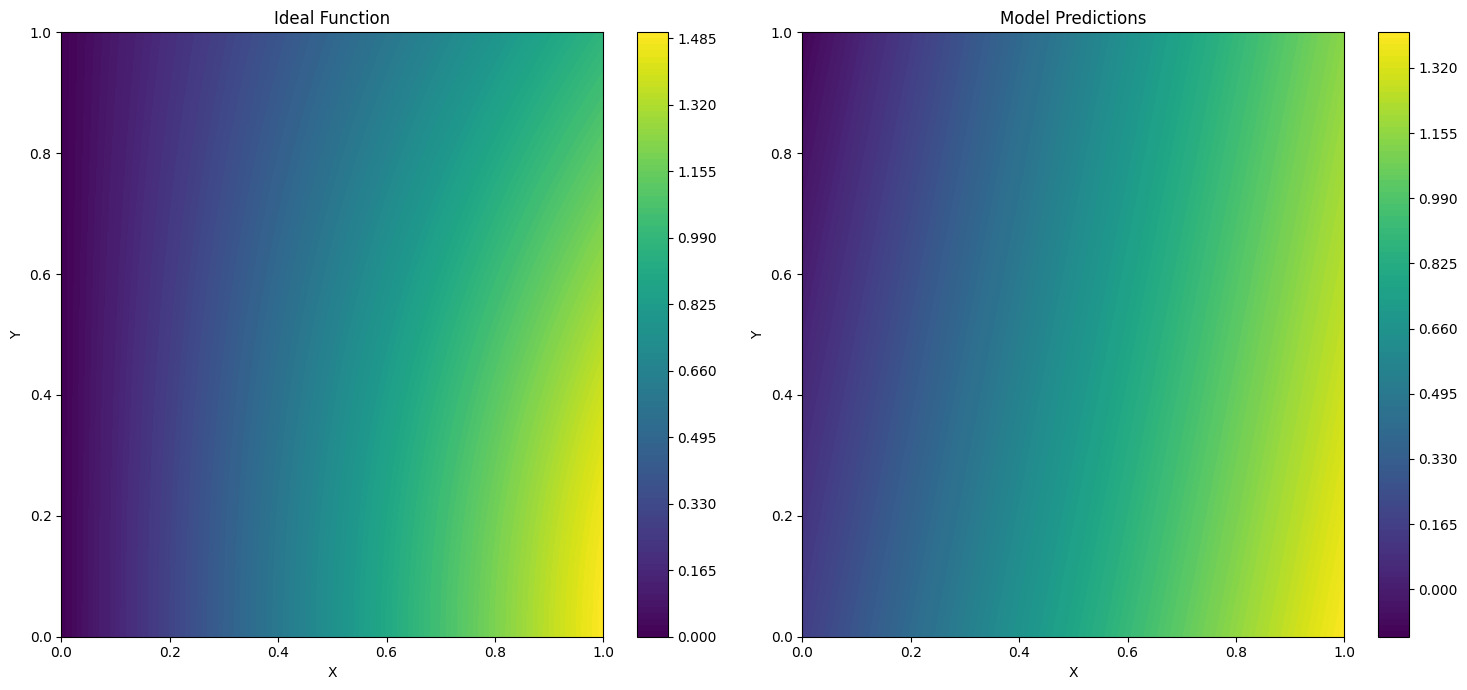

Training time: 85.61773807800091, mse: 0.003045796882096314, r2: 0.9808991914726809


In [56]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_5, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.45e+00 : 100%|███████| 72/72 [01:26<00:00,  1.20s/it]


Training time in seconds of lr=0.05: 86.62373261099856
Learning Rate: 0.05, Train MSE: 0.0035087884719808525, Train r2: 0.9779956775318376


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:26<00:00,  1.20s/it]


Training time in seconds of lr=0.1: 86.1284668979988
Learning Rate: 0.1, Train MSE: 0.003044842982037772, Train r2: 0.980905173572958


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.23e+00 : 100%|███████| 72/72 [01:24<00:00,  1.17s/it]


Training time in seconds of lr=0.2: 84.52472474200113
Learning Rate: 0.2, Train MSE: 0.0030448231262520486, Train r2: 0.9809052980926078
Best Learning Rate: 0.2 with Train MSE: 0.0030448231262520486


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.23e+00 : 100%|███████| 72/72 [01:25<00:00,  1.19s/it]


Training time in seconds: 85.54168619499978
Layer 0 Bezier coefficients:
[[ 0.5070778  -0.8924869 ]
 [-0.1794216   0.31158265]]
Layer 1 Bezier coefficients:
[[ 0.38176605 -0.11849156]]


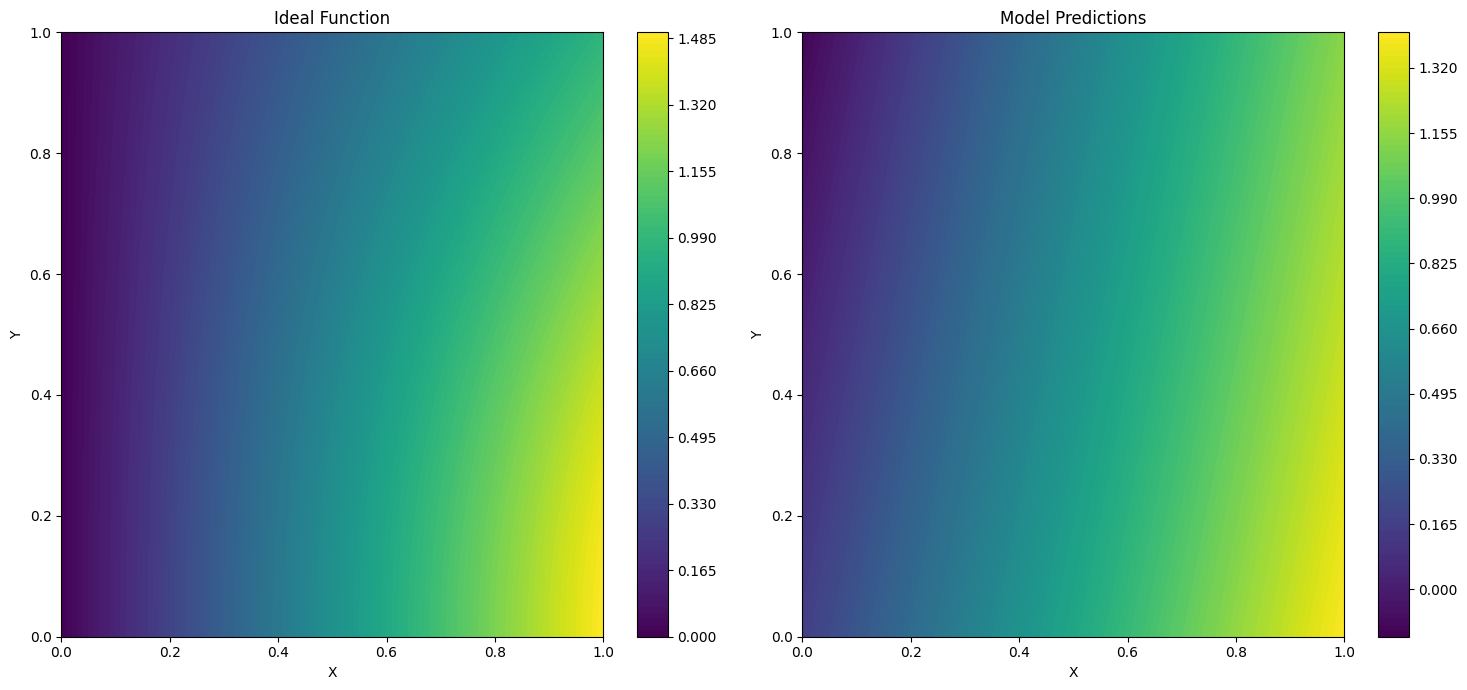

Training time: 85.54168619499978, mse: 0.003044887402130319, r2: 0.9809048950055698


In [57]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_5, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [58]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 3.2160105869996087
MSE: 0.0031, r2: 0.9803
Simulated Annealing Metrics
Total run time in seconds: 13.515000682999016
MSE: 0.0031, r2: 0.9803
Adam Optimizer Metrics
Total run time in seconds: 87.39930037799968
MSE: 0.0028, r2: 0.9824
SGD Optimizer Metrics
Total run time in seconds: 85.61773807800091
MSE: 0.0030, r2: 0.9809
AdaGrad Optimizer Metrics
Total run time in seconds: 85.54168619499978
MSE: 0.0030, r2: 0.9809
Array of time for quantum in each training/retraining: [4.032177162000449, 3.227566368000397, 3.2470713929992128, 3.2536777089999367, 3.2160105869996087], total time: 16.976503218999607
Array of time for simulated in each training/retraining: [14.029242445000818, 13.24871691000044, 13.658208154999556, 13.41436722799881, 13.515000682999016], total time: 67.86553542099864
Array of time for adam in each training/retraining: [72.16724453000006, 74.71706445099971, 81.03533444499953, 85.29869635200157, 87.39930037799968], total

# Save the datasets

In [59]:
import pickle

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset1.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 1 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset2.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 2 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset3.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 3 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset4.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 4 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset5.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 5 saved to {dataset_file}")

Dataset 1 saved to dataset_2_1_35_18_retraining_m1_1_dataset1.pkl
Dataset 2 saved to dataset_2_1_35_18_retraining_m1_1_dataset2.pkl
Dataset 3 saved to dataset_2_1_35_18_retraining_m1_1_dataset3.pkl
Dataset 4 saved to dataset_2_1_35_18_retraining_m1_1_dataset4.pkl
Dataset 5 saved to dataset_2_1_35_18_retraining_m1_1_dataset5.pkl
